In [24]:
import numpy as np
import scipy as sp
import math as m

import scipy.io
from scipy.signal import butter, lfilter
from scipy.interpolate import griddata
from scipy.misc import bytescale

from itertools import chain
from functools import reduce

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer, scale
from sklearn.metrics import roc_auc_score

import re
import h5py
import csv

import matplotlib.pyplot as plt

plt.style.use('ggplot')

np.random.seed(777)
%matplotlib inline

In [2]:
TRAIN_FILE = "train.h5"
TEST_FILE = "test.h5"
SAMPLING_RATE = 250

In [3]:
CHANNEL_NAMES = np.array(['T5', 'T3', 'F7', 'F3', 'C3', 'P3', 'Fp1', 'Fpz', 'A1', 'O1', 'Cz', 'Oz', 'Fz', 'Pz', 'O2', 'A2', 'Fp2', 'P4', 'C4', 'F4', 'F8', 'T4', 'T6', 'AUX'])
CHANNELS_TO_DISCARD = ['A1', 'A2', 'AUX']
EYE_CHANNEL = "Fp1"
CSP_FREQUENCES = [(6,10),(8,12),(10,14),(12,16),(14,18),(16,20),(18,22),(20,24),
                     (22,26),(24,28),(26,30),(28,32),(30,34),(32,36),(34,38)]

In [4]:
def butter_bandpass(lowcut, highcut, sampling_rate, order=5):
    """
    For a given order (5 by default), computes numerator (b)
    and denominator (a) polynomials
    of the IIR filter (bandpass between lowcut and highcut).
    """
    nyq_freq = sampling_rate*0.5
    low = lowcut/nyq_freq
    high = highcut/nyq_freq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_high_low_pass(lowcut, highcut, sampling_rate, order=5):
    """
    For a given order (5 by default), computes numerator (b_high, b_low)
    and denominator (a_high, a_low) polynomials of the IIR filters
    (highpass for lowcut, lowpass for highcut).
    """
    nyq_freq = sampling_rate*0.5
    lower_bound = lowcut/nyq_freq
    higher_bound = highcut/nyq_freq
    b_high, a_high = butter(order, lower_bound, btype='high')
    b_low, a_low = butter(order, higher_bound, btype='low')
    return b_high, a_high, b_low, a_low

def butter_bandpass_filter(data, lowcut, highcut, sampling_rate, order=5, how_to_filt = 'separately'):
    """
    Applies Butterworth bandpass filter (with a given order, 5 by default) to the data.
    If how_to_filt = 'separately', applies highpass than lowpass, and thus results
        in bandpass between lowcut and highcut.
    If how_to_filt == 'simultaneously', applies bandpass directly.
    """
    if how_to_filt == 'separately':
        b_high, a_high, b_low, a_low = butter_high_low_pass(lowcut, highcut, sampling_rate, order=order)
        y = lfilter(b_high, a_high, data)
        y = lfilter(b_low, a_low, y)
    elif how_to_filt == 'simultaneously':
        b, a = butter_bandpass(lowcut, highcut, sampling_rate, order=order)
        y = lfilter(b, a, data)
    return y

In [5]:
def remove_outliers(data, iter_numb):
    """
    Repetitively (specified by iter_numb) applies outliers removal to the data:
    deletes samples which power deviates more than 2.5 SDs from the mean.
    """
    data_pwr = np.sqrt(np.sum(data**2, 0))
    mask = np.ones(data.shape[1], dtype=np.bool)
    for i in range(iter_numb):
        X_mean = np.mean(data_pwr[mask])
        X_std = np.std(data_pwr[mask])
        mask &= np.abs(data_pwr - X_mean) < 2.5*np.abs(X_std)
        print('Samples left after outliers removal: %d' % mask.sum())
    return mask

def remove_eog_simple(data, channel_names, number_artefact_components=3):
    """
    Blinks and eye artefacts removal by singular value decomposition.
    
    Arguments:
    data: EEG data, numpy array [n_channels, n_samples]
    eyechan: channel nummer used for artefacts detection
    number_artefact_components: number of eigenvalues used - the number
       of components the artefacts are presumed to have
       
    Returns artefact-free EEG time series and the matrix of corresponding transformation
    """
    only_eye_chan = data[channel_names == EYE_CHANNEL, :]
    exceed_mask = only_eye_chan > 3*np.mean(np.absolute(only_eye_chan))
    print('Number of samples identified as containing eye artefacts: %d' % np.sum(exceed_mask))
    U, S, V = np.linalg.svd(data[:, exceed_mask[0,:]], full_matrices=True)
    M_eog = np.eye(U.shape[0])-np.dot(U[:,0:number_artefact_components],U[:,0:number_artefact_components].T)
    
    return np.dot(M_eog, data), M_eog

In [6]:
def outer_n(n):
    return np.array(list(range(n))+list(range(-n,0)))

def whitener(C, rtol=1e-15):
    e, E = np.linalg.eigh(C)
    return reduce(np.dot, [E, np.diag(np.where(e > np.max(e) * rtol, e, np.inf)**-0.5), E.T])

def csp_base(C_a, C_b):
    P = whitener(C_a + C_b)
    P_C_b = reduce(np.dot, [P, C_b, P.T])
    _, _, B = np.linalg.svd((P_C_b))
    return np.dot(B, P.T)

def csp(C_a, C_b, m):
    W = csp_base(C_a, C_b)
    assert W.shape[1] >= 2*m
    return W[outer_n(m)]

In [7]:
def filter_eeg(eeg_data, sampling_rate, channel_names):
    # Prefilter eeg data
    eeg_data = butter_bandpass_filter(eeg_data, 0.5, 45, sampling_rate, order=5, how_to_filt='separately')
    
    # Remove empty channels
    # Detect constant (zero) channels
    channels_mask = np.ones(len(channel_names), dtype=np.bool)
    for channel in CHANNELS_TO_DISCARD:
        channels_mask &= (channel_names != channel)
        
    nozeros_mask = np.sum(eeg_data[:, :sampling_rate * 2], 1) != 0
    without_emp_mask = nozeros_mask & channels_mask
    
    # Remove constant (zero) channels and prespecified channels
    eeg_data = eeg_data[without_emp_mask, :]
    channel_names = channel_names[without_emp_mask]
    
    return eeg_data, channel_names

In [8]:
numbergetter = re.compile(r"\d+$")
def get_tail_number(string):
    return int(numbergetter.findall(string)[0])

In [9]:
import mne

def load_raw_data(data, selected_channels, montage):
    info = mne.create_info(ch_names=list(selected_channels), 
                           sfreq=SAMPLING_RATE,
                           ch_types='eeg',
                           montage=montage)
    
    return mne.io.RawArray(data, info=info)

def load_montage_information(filename):
    assert filename.endswith('.mat')
    
    mat = sp.io.loadmat(filename)    
    point_labels = [mat[0] for mat in mat['labels']]
    point_data = [mat['x_coord'], mat['y_coord'], mat['z_coord']]
    points = np.concatenate(point_data, axis=1)
    
    assert len(points) == len(point_labels)
    return mne.channels.Montage(pos=points, ch_names=point_labels, kind=None, selection=range(len(points)))

def process_raw_data(eeg_data):
    
    filtered_eeg, selected_channels = filter_eeg(eeg_data, SAMPLING_RATE, CHANNEL_NAMES)
    
    # Remove outliers; remove artefacts (blinks, eye movements)
    eye_channel_index = (selected_channels == EYE_CHANNEL)
    selected_items = remove_outliers(filtered_eeg, 7)
    filtered_eeg, M_eog = remove_eog_simple(filtered_eeg, selected_channels)
    
    return filtered_eeg, selected_channels

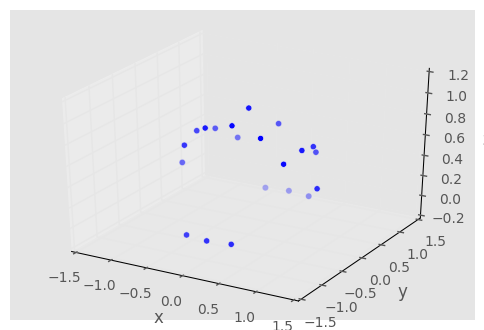

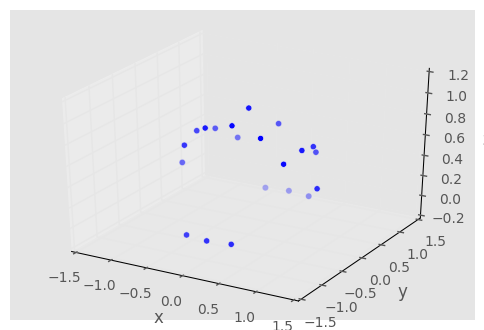

In [10]:
montage_data = load_montage_information('./electrode_locations_besa_unit_sphere.mat')
montage_data.plot()

In [11]:
train_data = {}
train_labels = {}

with h5py.File(TRAIN_FILE, 'r') as data_file:
    
    for subject, subject_data in data_file.items():
    
        data = subject_data['data'][()]    
    
        data, selected_channels = process_raw_data(data)
        train_data[subject] = {
            'data': load_raw_data(data, selected_channels, montage_data),
            'channels': selected_channels,
            'labels':  subject_data['labels'][()]
        } 
    
train_data

Samples left after outliers removal: 100390
Samples left after outliers removal: 98884
Samples left after outliers removal: 95921
Samples left after outliers removal: 93717
Samples left after outliers removal: 92399
Samples left after outliers removal: 91637
Samples left after outliers removal: 91217
Number of samples identified as containing eye artefacts: 1001
Creating RawArray with float64 data, n_channels=20, n_times=100826
    Range : 0 ... 100825 =      0.000 ...   403.300 secs
Ready.
Samples left after outliers removal: 54905
Samples left after outliers removal: 54110
Samples left after outliers removal: 52485
Samples left after outliers removal: 51002
Samples left after outliers removal: 49992
Samples left after outliers removal: 49364
Samples left after outliers removal: 48988
Number of samples identified as containing eye artefacts: 929
Creating RawArray with float64 data, n_channels=20, n_times=55306
    Range : 0 ... 55305 =      0.000 ...   221.220 secs
Ready.
Samples left

{'subject_0': {'channels': array(['T5', 'T3', 'F7', 'F3', 'C3', 'P3', 'Fp1', 'Fpz', 'O1', 'Cz', 'Oz',
         'Fz', 'O2', 'Fp2', 'P4', 'C4', 'F4', 'F8', 'T4', 'T6'], 
        dtype='<U3'),
  'data': <RawArray  |  None, n_channels x n_times : 20 x 100826 (403.3 sec), ~15.4 MB, data loaded>,
  'labels': array([[0, 0, 0, ..., 2, 2, 2]])},
 'subject_1': {'channels': array(['T5', 'T3', 'F7', 'F3', 'C3', 'P3', 'Fp1', 'Fpz', 'O1', 'Cz', 'Oz',
         'Fz', 'O2', 'Fp2', 'P4', 'C4', 'F4', 'F8', 'T4', 'T6'], 
        dtype='<U3'),
  'data': <RawArray  |  None, n_channels x n_times : 20 x 55306 (221.2 sec), ~8.5 MB, data loaded>,
  'labels': array([[2, 2, 2, ..., 2, 2, 2]])},
 'subject_2': {'channels': array(['T5', 'T3', 'F7', 'F3', 'C3', 'P3', 'Fp1', 'Fpz', 'O1', 'Cz', 'Oz',
         'Fz', 'O2', 'Fp2', 'P4', 'C4', 'F4', 'F8', 'T4', 'T6'], 
        dtype='<U3'),
  'data': <RawArray  |  None, n_channels x n_times : 20 x 54457 (217.8 sec), ~8.4 MB, data loaded>,
  'labels': array([[0, 0, 0, ..., 

In [12]:
subject_data = train_data['subject_0']
subject_data

{'channels': array(['T5', 'T3', 'F7', 'F3', 'C3', 'P3', 'Fp1', 'Fpz', 'O1', 'Cz', 'Oz',
        'Fz', 'O2', 'Fp2', 'P4', 'C4', 'F4', 'F8', 'T4', 'T6'], 
       dtype='<U3'),
 'data': <RawArray  |  None, n_channels x n_times : 20 x 100826 (403.3 sec), ~15.4 MB, data loaded>,
 'labels': array([[0, 0, 0, ..., 2, 2, 2]])}

In [13]:
def azim_proj(pos):
    """
    Computes the Azimuthal Equidistant Projection of input point in 3D Cartesian Coordinates.
    Imagine a plane being placed against (tangent to) a globe. If
    a light source inside the globe projects the graticule onto
    the plane the result would be a planar, or azimuthal, map
    projection.

    :param pos: position in 3D Cartesian coordinates
    :return: projected coordinates using Azimuthal Equidistant Projection
    """
    [r, elev, az] = cart2sph(pos[0], pos[1], pos[2])
    return pol2cart(az, m.pi / 2 - elev)

In [14]:
def gen_images(locs, features, img_size, normalize=True, n_bands=3,
               augment=False, pca=False, stdMult=0.1, n_components=2, edgeless=False):
    """
    Generates EEG images given electrode locations in 2D space and multiple feature values for each electrode

    :param loc: An array with shape [n_electrodes, 2] containing X, Y
                        coordinates for each electrode.
    :param features: Feature matrix as [n_samples, n_features]
                                Features are as columns.
                                Features corresponding to each frequency band are concatenated.
                                (alpha1, alpha2, ..., beta1, beta2,...)
    :param img_size:    Number of pixels in the output images
    :param normalize:   Flag for whether to normalize each feature over all samples
    :param augment:     Flag for generating augmented images
    :param pca:         Flag for PCA based data augmentation
    :param stdMult:     Standard deviation of noise for augmentation
    :param n_components: Number of components in PCA to retain for augmentation
    :param edgeless:    If True generates edgeless images by adding artificial channels
                        at four corners of th  e image with value = 0 (default=False).
    :return:            Tensor of size [samples, colors, W, H] containing generated
                        images.
    """

    feat_array_temp = []
    nElectrodes = locs.shape[0]     # Number of electrodes

    # Test whether the feature vector length is divisible by number of electrodes
    assert features.shape[1] % nElectrodes == 0
    
    n_colors = features.shape[1] // nElectrodes
    
    print('Colors: ' + str(n_colors))
    
    for c in range(n_colors):
        feat_array_temp.append(features[:, c * nElectrodes : nElectrodes * (c+1)])

    if augment:
        if pca:
            for c in range(n_colors):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], stdMult, pca=True, n_components=n_components)
        else:
            for c in range(n_colors):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], stdMult, pca=False, n_components=n_components)

    nSamples = features.shape[0]
    
    minx, maxx = np.asscalar(min(locs[:, 0])), np.asscalar(max(locs[:, 0]))
    miny, maxy = np.asscalar(min(locs[:, 1])), np.asscalar(max(locs[:, 1]))
        
    print('Minx:', minx, 'Maxx:', maxx)
    print('Miny:', miny, 'Maxy:', maxy)
    print('Image size', img_size, 'x', img_size)
    
    # Interpolate the values
    grid_x, grid_y = np.meshgrid(np.linspace(minx, maxx, img_size), np.linspace(miny,maxy,img_size))
    
    temp_interp = []
    for c in range(n_colors):
        temp_interp.append(np.zeros([nSamples, img_size, img_size]))

    # Generate edgeless images
    if edgeless:
        min_x, min_y = np.min(locs, axis=0)
        max_x, max_y = np.max(locs, axis=0)
        locs = np.append(locs, np.array([[min_x, min_y], [min_x, max_y],[max_x, min_y],[max_x, max_y]]),axis=0)
        for c in range(n_colors):
            feat_array_temp[c] = np.append(feat_array_temp[c], np.zeros((nSamples, 4)), axis=1)

    for i in range(nSamples):
        
        if i%1000 == 0:
            print('Interpolating {0}/{1}\r'.format(i+1, nSamples))
        
        for c in range(n_colors):
            values = feat_array_temp[c][i, :]
            interpolated_values = griddata(locs, values, (grid_x, grid_y), method='cubic')
            temp_interp[c][i, :, :] = np.nan_to_num(interpolated_values)

    for c in range(n_colors):
        if normalize:
            temp_interp[c][~np.isnan(temp_interp[c])] = \
                scale(temp_interp[c][~np.isnan(temp_interp[c])])
                
    return np.swapaxes(np.asarray(temp_interp), 0, 1)     # swap axes to have [samples, colors, W, H]

In [15]:
import math as m
import numpy as np
import scipy.io
from sklearn.decomposition import PCA

def cart2sph(x, y, z):
    """
    Transform Cartesian coordinates to spherical
    :param x: X coordinate
    :param y: Y coordinate
    :param z: Z coordinate
    :return: radius, elevation, azimuth
    """
    x2_y2 = x**2 + y**2
    r = m.sqrt(x2_y2 + z**2)                    # r
    elev = m.atan2(z, m.sqrt(x2_y2))            # Elevation
    az = m.atan2(y, x)                          # Azimuth
    return r, elev, az


def pol2cart(theta, rho):
    """
    Transform polar coordinates to Cartesian
    :param theta: angle value
    :param rho: radius value
    :return: X, Y
    """
    return rho * m.cos(theta), rho * m.sin(theta)


def augment_EEG(data, stdMult, pca=False, n_components=2):
    """
    Augment data by adding normal noise to each feature.
    :param data: EEG feature data as a matrix (n_samples x n_features)
    :param stdMult: Multiplier for std of added noise
    :param pca: if True will perform PCA on data and add noise proportional to PCA components.
    :param n_components: Number of components to consider when using PCA.
    :return: Augmented data as a matrix (n_samples x n_features)
    """
    augData = np.zeros(data.shape)
    if pca:
        pca = PCA(n_components=n_components)
        pca.fit(data)
        components = pca.components_
        variances = pca.explained_variance_ratio_
        coeffs = np.random.normal(scale=stdMult, size=pca.n_components) * variances
        for s, sample in enumerate(data):
            augData[s, :] = sample + (components * coeffs.reshape((n_components, -1))).sum(axis=0)
    else:
        # Add Gaussian noise with std determined by weighted std of each feature
        for f, feat in enumerate(data.transpose()):
            augData[:, f] = feat + np.random.normal(scale=stdMult*np.std(feat), size=feat.size)
    return augData


def augment_EEG_image(image, stdMult, pca=False, n_components=2):
    """
    Augment data by adding normal noise to each feature.
    :param image: EEG feature data as a a colored image [n_samples, n_colors, W, H]
    :param stdMult: Multiplier for std of added noise
    :param pca: if True will perform PCA on data and add noise proportional to PCA components.
    :param n_components: Number of components to consider when using PCA.
    :return: Augmented data as a matrix (n_samples x n_features)
    """
    augData = np.zeros((data.shape[0], data.shape[1], data.shape[2] * data.shape[3]))
    for c in range(image.shape[1]):
        reshData = np.reshape(data['featMat'][:, c, :, :], (data['featMat'].shape[0], -1))
        if pca:
            augData[:, c, :] = augment_EEG(reshData, stdMult, pca=True, n_components=n_components)
        else:
            augData[:, c, :] = augment_EEG(reshData, stdMult, pca=False)
    return np.reshape(augData, data['featMat'].shape)

In [16]:
train_data

{'subject_0': {'channels': array(['T5', 'T3', 'F7', 'F3', 'C3', 'P3', 'Fp1', 'Fpz', 'O1', 'Cz', 'Oz',
         'Fz', 'O2', 'Fp2', 'P4', 'C4', 'F4', 'F8', 'T4', 'T6'], 
        dtype='<U3'),
  'data': <RawArray  |  None, n_channels x n_times : 20 x 100826 (403.3 sec), ~15.4 MB, data loaded>,
  'labels': array([[0, 0, 0, ..., 2, 2, 2]])},
 'subject_1': {'channels': array(['T5', 'T3', 'F7', 'F3', 'C3', 'P3', 'Fp1', 'Fpz', 'O1', 'Cz', 'Oz',
         'Fz', 'O2', 'Fp2', 'P4', 'C4', 'F4', 'F8', 'T4', 'T6'], 
        dtype='<U3'),
  'data': <RawArray  |  None, n_channels x n_times : 20 x 55306 (221.2 sec), ~8.5 MB, data loaded>,
  'labels': array([[2, 2, 2, ..., 2, 2, 2]])},
 'subject_2': {'channels': array(['T5', 'T3', 'F7', 'F3', 'C3', 'P3', 'Fp1', 'Fpz', 'O1', 'Cz', 'Oz',
         'Fz', 'O2', 'Fp2', 'P4', 'C4', 'F4', 'F8', 'T4', 'T6'], 
        dtype='<U3'),
  'data': <RawArray  |  None, n_channels x n_times : 20 x 54457 (217.8 sec), ~8.4 MB, data loaded>,
  'labels': array([[0, 0, 0, ..., 

In [17]:
subject_data = train_data['subject_1']

In [18]:
subject_df = subject_data['data'].to_data_frame()
subject_df.head(3)

Converting time column to int64...


signal,T5,T3,F7,F3,C3,P3,Fp1,Fpz,O1,Cz,Oz,Fz,O2,Fp2,P4,C4,F4,F8,T4,T6
time,,,,,,,,,,,,,,,,,,,,
0,133.474196,0.130659,3.595742,-78.190178,-128.292899,90.218054,-7.833406,-8.706401,111.873861,2.936560,104.311212,-184.228330,122.359888,140.200774,41.760043,-97.922213,-38.671840,-26.719631,-135.768648,10.130271
4,2067.155442,52.766493,41.601404,-1140.356597,-1864.079078,1384.606565,-97.359752,-69.718025,1658.432589,84.357881,1457.252117,-2797.806590,1787.996494,2002.528143,595.428581,-1447.526439,-616.222288,-313.321917,-1990.130407,208.350466
8,15286.074449,803.772875,218.269216,-7941.392583,-12907.467521,10174.435251,-553.734635,-55.962629,11938.689826,935.755376,9724.659814,-20364.771442,12433.573033,13657.980021,4018.907317,-10290.110507,-4798.744716,-1532.111759,-13919.781234,1855.859148


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0b6ae003c8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f0b6a89f208>], dtype=object)

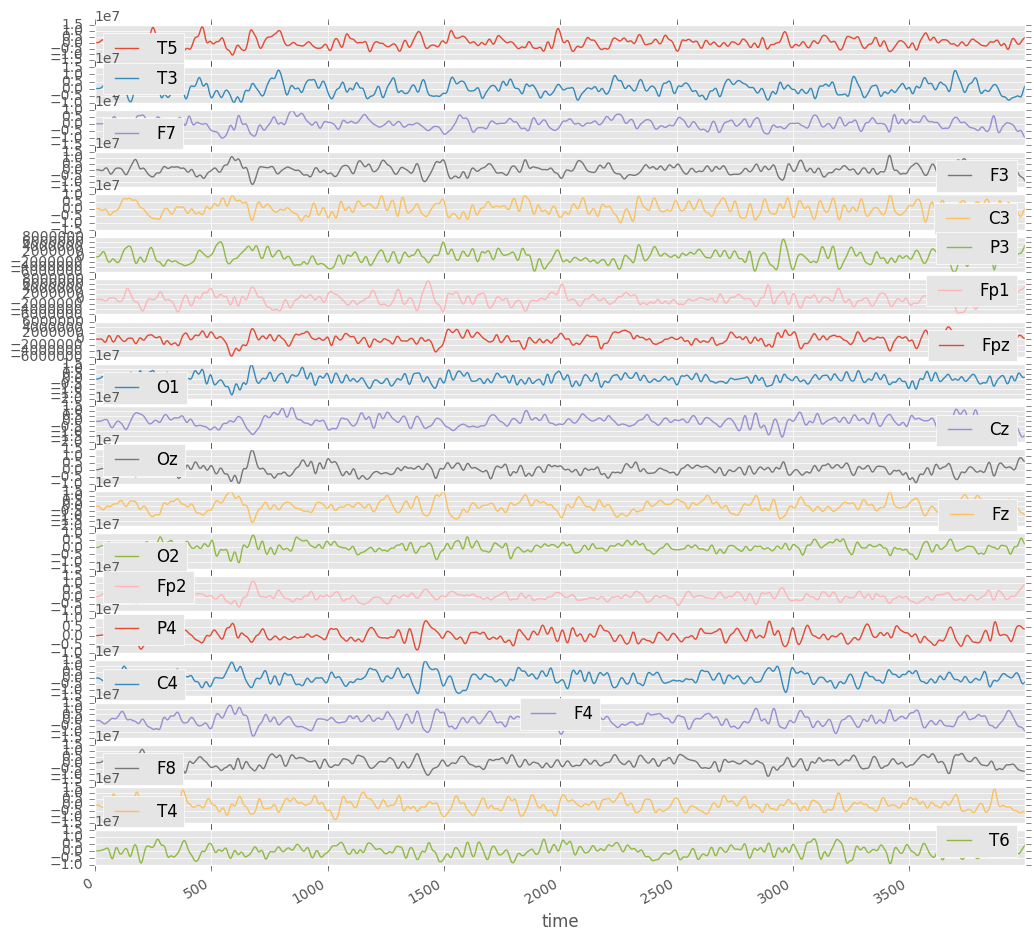

In [19]:
subject_df[:1000].plot(figsize=(12, 12), subplots=True)

In [20]:
pos3d = montage_data.pos
pos2d = np.matrix([azim_proj(p) for p in pos3d])

print(pos2d.shape)

(21, 2)


In [21]:
features = subject_df.as_matrix()
print(features.shape)

(55306, 20)


In [22]:
used_electrodes_index = [c in subject_data['channels'] for c in montage_data.ch_names]
electrode_positions = pos2d[np.array(used_electrodes_index), :]

print(electrode_positions.shape)

(20, 2)


In [25]:
images = gen_images(electrode_positions, features, img_size=16, augment=True, pca=True, n_components=2)

Colors: 1
Minx: -1.2042769839295635 Maxx: 1.2042769839295635
Miny: -1.6057024093979915 Maxy: 1.6057024093979915
Image size 16 x 16
Interpolating 1/55306
Interpolating 1001/55306
Interpolating 2001/55306
Interpolating 3001/55306
Interpolating 4001/55306
Interpolating 5001/55306
Interpolating 6001/55306
Interpolating 7001/55306
Interpolating 8001/55306
Interpolating 9001/55306
Interpolating 10001/55306
Interpolating 11001/55306
Interpolating 12001/55306
Interpolating 13001/55306
Interpolating 14001/55306
Interpolating 15001/55306
Interpolating 16001/55306
Interpolating 17001/55306
Interpolating 18001/55306
Interpolating 19001/55306
Interpolating 20001/55306
Interpolating 21001/55306
Interpolating 22001/55306
Interpolating 23001/55306
Interpolating 24001/55306
Interpolating 25001/55306
Interpolating 26001/55306
Interpolating 27001/55306
Interpolating 28001/55306
Interpolating 29001/55306
Interpolating 30001/55306
Interpolating 31001/55306
Interpolating 32001/55306
Interpolating 33001/5530

In [26]:
def show_image(image):
    pixel_data = np.apply_along_axis(np.asscalar, 2, image.transpose(1,2,0))
    plt.imshow(pixel_data)

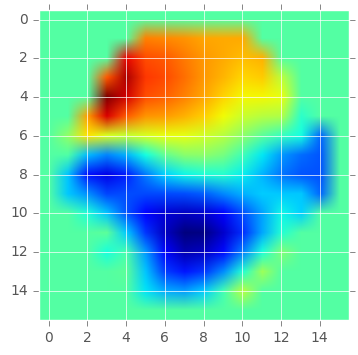

In [27]:
show_image(images[0])

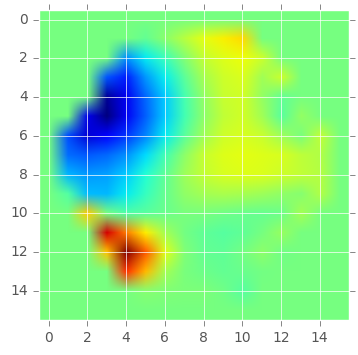

In [28]:
show_image(images[101])

In [29]:
import theano
import theano.tensor as T

import lasagne
from lasagne.layers import Conv2DLayer, MaxPool2DLayer, InputLayer
from lasagne.layers import DenseLayer, ElemwiseMergeLayer, FlattenLayer
from lasagne.layers import ConcatLayer, ReshapeLayer, get_output_shape
from lasagne.layers import Conv1DLayer, DimshuffleLayer, LSTMLayer, SliceLayer

def build_cnn(input_var=None, W_init=None, n_layers=(4, 2, 1), n_filters_first=32, imSize=32, n_colors=3):
    """
    Builds a VGG style CNN network followed by a fully-connected layer and a softmax layer.
    Stacks are separated by a maxpool layer. Number of kernels in each layer is twice
    the number in previous stack.
    input_var: Theano variable for input to the network
    outputs: pointer to the output of the last layer of network (softmax)

    :param input_var: theano variable as input to the network
    :param n_layers: number of layers in each stack. An array of integers with each
                    value corresponding to the number of layers in each stack.
                    (e.g. [4, 2, 1] == 3 stacks with 4, 2, and 1 layers in each.
    :param n_filters_first: number of filters in the first layer
    :param W_init: Initial weight values
    :param imSize: Size of the image
    :param n_colors: Number of color channels (depth)
    :return: a pointer to the output of last layer
    """

    weights = []        # Keeps the weights for all layers
    count = 0
    # If no initial weight is given, initialize with GlorotUniform
    if W_init is None:
        W_init = [lasagne.init.GlorotUniform()] * sum(n_layers)

    # Input layer
    network = InputLayer(shape=(None, n_colors, imSize, imSize),
                                        input_var=input_var)

    for i, s in enumerate(n_layers):
        for l in range(s):
            network = Conv2DLayer(network, num_filters=n_filters_first * (2 ** i), filter_size=(3, 3),
                          W=W_init[count], pad='same')
            count += 1
            weights.append(network.W)
        network = MaxPool2DLayer(network, pool_size=(2, 2))


    return network, weights

/home/ubuntu/anaconda3/envs/py3_env/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [49]:
def build_convpool_lstm(input_vars, nb_classes, GRAD_CLIP=100, imSize=32, n_colors=3, n_timewin=3):
    """
    Builds the complete network with LSTM layer to integrate time from sequences of EEG images.
    :param input_vars: list of EEG images (one image per time window)
    :param nb_classes: number of classes
    :param GRAD_CLIP:  the gradient messages are clipped to the given value during
                        the backward pass.
    :return: a pointer to the output of last layer
    """
    convnets = []
    
    W_init = None

    for i in range(n_timewin):
        if i == 0:
            convnet, W_init = build_cnn(input_vars, imSize=imSize, n_colors=n_colors)
        else:
            convnet, _ = build_cnn(input_vars, W_init=W_init, imSize=imSize, n_colors=n_colors)
                
        convnets.append(FlattenLayer(convnet))
        input_vars = T.roll(input_vars, -1)
        
        
    # at this point convnets shape is [numTimeWin][n_samples, features]
    # we want the shape to be [n_samples, features, numTimeWin]
    convnet_shape = get_output_shape(convnets[0])[1]
    
    convpool = ConcatLayer(convnets)
    convpool = ReshapeLayer(convpool, ([0], n_timewin, convnet_shape))
    
    # Input to LSTM should have the shape as (batch size, SEQ_LENGTH, num_features)
    convpool = LSTMLayer(convpool, num_units=128, grad_clipping=GRAD_CLIP,
        nonlinearity=lasagne.nonlinearities.tanh)

    
    convpool = SliceLayer(convpool, -1, 1) # Selecting the last prediction
    convpool = DenseLayer(lasagne.layers.dropout(convpool, p=.5), 
                          num_units=256, 
                          nonlinearity=lasagne.nonlinearities.rectify)

    convpool = DenseLayer(lasagne.layers.dropout(convpool, p=.5),
            num_units=nb_classes, nonlinearity=lasagne.nonlinearities.softmax)
    
    return convpool

In [50]:
labels = subject_data['labels'][0].astype(np.int32)
labels

array([2, 2, 2, ..., 2, 2, 2], dtype=int32)

In [51]:
labels.dtype

dtype('int32')

In [61]:
X = T.TensorType('floatX', ((False,) * 4))()
y = T.ivector('labels')

In [62]:
network = build_cnn(X)

In [63]:
# create loss function
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, y)
loss = loss.mean() + 1e-4 * lasagne.regularization.regularize_network_params(
        network, lasagne.regularization.l2)

# create parameter update expressions
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.01, momentum=0.9)

# compile training function that updates parameters and returns training loss
train_fn = theano.function(
    [X, y], 
    loss, 
    updates=updates)

TypeError: unhashable type: 'list'

In [36]:
images.shape

(55306, 1, 16, 16)

In [ ]:
EPOCH_COUNT = 100
BATCH_SIZE = 100

T.config.optimizer='fast_compile'
T.config.exception_verbosity = 'high'

# train network (assuming you've got some training data in numpy arrays)
for epoch in range(EPOCH_COUNT):
    loss = 0
    for i in range(0, len(images), BATCH_SIZE):
        
        batch_images = images[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :, :]
        batch_labels = labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        
        loss += train_fn(batch_images, batch_labels)
        
    print("Epoch %d: Loss %g" % (epoch + 1, loss / len(training_data)))

In [55]:
EPOCH_COUNT = 100
BATCH_SIZE = 100

T.config.optimizer='fast_compile'
T.config.exception_verbosity = 'high'

# train network (assuming you've got some training data in numpy arrays)
for epoch in range(EPOCH_COUNT):
    loss = 0
    for i in range(0, len(images), BATCH_SIZE):
        
        batch_images = images[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :, :]
        batch_labels = labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        
        loss += train_fn(batch_images, batch_labels)
        
    print("Epoch %d: Loss %g" % (epoch + 1, loss / len(training_data)))

(100, 1, 16, 16)
(100,)


ValueError: total size of new array must be unchanged
Apply node that caused the error: Reshape{3}(Join.0, MakeVector{dtype='int64'}.0)
Toposort index: 583
Inputs types: [TensorType(float64, matrix), TensorType(int64, vector)]
Inputs shapes: [(100, 2560), (3,)]
Inputs strides: [(20480, 8), (8,)]
Inputs values: ['not shown', array([ 100,    5, 2048])]
Outputs clients: [[InplaceDimShuffle{1,0,2}(Reshape{3}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/home/ubuntu/anaconda3/envs/py3_env/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/anaconda3/envs/py3_env/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/py3_env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/anaconda3/envs/py3_env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ubuntu/anaconda3/envs/py3_env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-54-8096dd617284>", line 2, in <module>
    prediction = lasagne.layers.get_output(network)
  File "/home/ubuntu/anaconda3/envs/py3_env/lib/python3.5/site-packages/lasagne/layers/helper.py", line 185, in get_output
    all_outputs[layer] = layer.get_output_for(layer_inputs, **kwargs)
  File "/home/ubuntu/anaconda3/envs/py3_env/lib/python3.5/site-packages/lasagne/layers/shape.py", line 183, in get_output_for
    return input.reshape(tuple(output_shape))

Debugprint of the apply node: 
Reshape{3} [id A] <TensorType(float64, 3D)> ''   
 |Join [id B] <TensorType(float64, matrix)> ''   
 | |TensorConstant{1} [id C] <TensorType(int8, scalar)>
 | |Reshape{2} [id D] <TensorType(float64, matrix)> ''   
 | | |Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'} [id E] <TensorType(float64, 4D)> ''   
 | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id F] <TensorType(float64, 4D)> ''   
 | | |   |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   |Elemwise{add,no_inplace} [id H] <TensorType(float64, 4D)> ''   
 | | |   | |Subtensor{::, ::, int64:int64:, int64:int64:} [id I] <TensorType(float64, 4D)> ''   
 | | |   | | |CorrMM{full, (1, 1)} [id J] <TensorType(float64, 4D)> ''   
 | | |   | | | |Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'} [id K] <TensorType(float64, 4D)> ''   
 | | |   | | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}[(0, 2)] [id L] <TensorType(float64, 4D)> ''   
 | | |   | | | |   |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   |Elemwise{add,no_inplace} [id M] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | |Subtensor{::, ::, int64:int64:, int64:int64:} [id N] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | |CorrMM{full, (1, 1)} [id O] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id P] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   | | | | |Elemwise{add,no_inplace} [id Q] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id R] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | |CorrMM{full, (1, 1)} [id S] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'} [id T] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id U] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   | | | | | | | |   |Elemwise{add,no_inplace} [id V] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | |Subtensor{::, ::, int64:int64:, int64:int64:} [id W] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | |CorrMM{full, (1, 1)} [id X] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id Y] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   | | | | | | | |   | | | | |Elemwise{add,no_inplace} [id Z] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id BA] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |CorrMM{full, (1, 1)} [id BB] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id BC] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   | | | | | | | |   | | | | | | | | |Elemwise{add,no_inplace} [id BD] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id BE] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |CorrMM{full, (1, 1)} [id BF] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id BG] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BH] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id BI] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |CorrMM{full, (1, 1)} [id BJ] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |images [id BK] <TensorType(float64, 4D)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |Subtensor{::, ::, ::int64, ::int64} [id BL] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |   |W [id BM] <TensorType(float64, 4D)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |   |Constant{-1} [id BN] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |   |Constant{-1} [id BN] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |ScalarFromTensor [id BP] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BQ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |   |Shape_i{2} [id BS] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |     |images [id BK] <TensorType(float64, 4D)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |ScalarFromTensor [id BT] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |   |Elemwise{add,no_inplace} [id BU] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |     |Shape_i{3} [id BV] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |       |images [id BK] <TensorType(float64, 4D)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |InplaceDimShuffle{x,0,x,x} [id BW] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | |   |b [id BX] <TensorType(float64, vector)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id BI] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | |InplaceDimShuffle{x,0,x,x} [id BW] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | |Subtensor{::, ::, ::int64, ::int64} [id BY] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |   |W [id BZ] <TensorType(float64, 4D)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |   |Constant{-1} [id BN] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |   |Constant{-1} [id BN] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |ScalarFromTensor [id CA] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | |Elemwise{add,no_inplace} [id CB] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |   |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id CC] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |Elemwise{add,no_inplace} [id BQ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |Shape_i{2} [id BS] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |ScalarFromTensor [id CH] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |   |Elemwise{add,no_inplace} [id CI] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id CJ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |Elemwise{add,no_inplace} [id BU] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |Shape_i{3} [id BV] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |InplaceDimShuffle{x,0,x,x} [id CK] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | |   |b [id CL] <TensorType(float64, vector)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id BE] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | |InplaceDimShuffle{x,0,x,x} [id CK] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | |Subtensor{::, ::, ::int64, ::int64} [id CM] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |   |W [id CN] <TensorType(float64, 4D)>
 | | |   | | | |   | | | | | | | |   | | | | | | |   |Constant{-1} [id BN] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | |   |Constant{-1} [id BN] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | |ScalarFromTensor [id CO] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | |Elemwise{add,no_inplace} [id CP] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |   |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id CQ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |     |Elemwise{add,no_inplace} [id CB] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id CC] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | |ScalarFromTensor [id CR] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |   |Elemwise{add,no_inplace} [id CS] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id CT] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |       |Elemwise{add,no_inplace} [id CI] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |       |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id CJ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |InplaceDimShuffle{x,0,x,x} [id CU] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | | |   |b [id CV] <TensorType(float64, vector)>
 | | |   | | | |   | | | | | | | |   | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id BA] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | |InplaceDimShuffle{x,0,x,x} [id CU] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | |Subtensor{::, ::, ::int64, ::int64} [id CW] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | |   |W [id CX] <TensorType(float64, 4D)>
 | | |   | | | |   | | | | | | | |   | | |   |Constant{-1} [id BN] <int64>
 | | |   | | | |   | | | | | | | |   | | |   |Constant{-1} [id BN] <int64>
 | | |   | | | |   | | | | | | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | |ScalarFromTensor [id CY] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | |Elemwise{add,no_inplace} [id CZ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | |   |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id DA] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | |     |Elemwise{add,no_inplace} [id CP] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | |     |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id CQ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | |     |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | |ScalarFromTensor [id DB] <int64> ''   
 | | |   | | | |   | | | | | | | |   | |   |Elemwise{add,no_inplace} [id DC] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id DD] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | |       |Elemwise{add,no_inplace} [id CS] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | |       |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | |       |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id CT] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | |       |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | |InplaceDimShuffle{x,0,x,x} [id DE] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   |   |b [id DF] <TensorType(float64, vector)>
 | | |   | | | |   | | | | | | | |   |Subtensor{::, ::, int64:int64:, int64:int64:} [id W] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   |InplaceDimShuffle{x,0,x,x} [id DE] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |Subtensor{::, ::, ::int64, ::int64} [id DG] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | |   |W [id DH] <TensorType(float64, 4D)>
 | | |   | | | |   | | | | | | |   |Constant{-1} [id BN] <int64>
 | | |   | | | |   | | | | | | |   |Constant{-1} [id BN] <int64>
 | | |   | | | |   | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | |ScalarFromTensor [id DI] <int64> ''   
 | | |   | | | |   | | | | | | | |Elemwise{add,no_inplace} [id DJ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | |   |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id DK] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | |     |Elemwise{add,no_inplace} [id CZ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | |     |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id DA] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | |     |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | |     |TensorConstant{2} [id DL] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | |ScalarFromTensor [id DM] <int64> ''   
 | | |   | | | |   | | | | | |   |Elemwise{add,no_inplace} [id DN] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | |     |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id DO] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | |       |Elemwise{add,no_inplace} [id DC] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | |       |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | |       |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id DD] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | |       |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | |       |TensorConstant{2} [id DL] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | |InplaceDimShuffle{x,0,x,x} [id DP] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | |   |b [id DQ] <TensorType(float64, vector)>
 | | |   | | | |   | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id R] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | |InplaceDimShuffle{x,0,x,x} [id DP] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | |Subtensor{::, ::, ::int64, ::int64} [id DR] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | |   |W [id DS] <TensorType(float64, 4D)>
 | | |   | | | |   | | |   |Constant{-1} [id BN] <int64>
 | | |   | | | |   | | |   |Constant{-1} [id BN] <int64>
 | | |   | | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | |ScalarFromTensor [id DT] <int64> ''   
 | | |   | | | |   | | | |Elemwise{add,no_inplace} [id DU] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | |   |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id DV] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | |     |Elemwise{add,no_inplace} [id DJ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | |     |TensorConstant{19} [id DW] <TensorType(int64, scalar)>
 | | |   | | | |   | | |     |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id DK] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | |     |TensorConstant{18} [id DX] <TensorType(int64, scalar)>
 | | |   | | | |   | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | |ScalarFromTensor [id DY] <int64> ''   
 | | |   | | | |   | |   |Elemwise{add,no_inplace} [id DZ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id EA] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | |       |Elemwise{add,no_inplace} [id DN] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | |       |TensorConstant{19} [id DW] <TensorType(int64, scalar)>
 | | |   | | | |   | |       |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id DO] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | |       |TensorConstant{18} [id DX] <TensorType(int64, scalar)>
 | | |   | | | |   | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | |InplaceDimShuffle{x,0,x,x} [id EB] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   |   |b [id EC] <TensorType(float64, vector)>
 | | |   | | | |   |Subtensor{::, ::, int64:int64:, int64:int64:} [id N] <TensorType(float64, 4D)> ''   
 | | |   | | | |   |InplaceDimShuffle{x,0,x,x} [id EB] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |Subtensor{::, ::, ::int64, ::int64} [id ED] <TensorType(float64, 4D)> ''   
 | | |   | | |   |W [id EE] <TensorType(float64, 4D)>
 | | |   | | |   |Constant{-1} [id BN] <int64>
 | | |   | | |   |Constant{-1} [id BN] <int64>
 | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | |ScalarFromTensor [id EF] <int64> ''   
 | | |   | | | |Elemwise{add,no_inplace} [id EG] <TensorType(int64, scalar)> ''   
 | | |   | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | |   |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id EH] <TensorType(int64, scalar)> ''   
 | | |   | | |     |Elemwise{add,no_inplace} [id DU] <TensorType(int64, scalar)> ''   
 | | |   | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | |     |TensorConstant{19} [id DW] <TensorType(int64, scalar)>
 | | |   | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id DV] <TensorType(int64, scalar)> ''   
 | | |   | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | |     |TensorConstant{18} [id DX] <TensorType(int64, scalar)>
 | | |   | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | |     |TensorConstant{2} [id DL] <TensorType(int64, scalar)>
 | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | |ScalarFromTensor [id EI] <int64> ''   
 | | |   | |   |Elemwise{add,no_inplace} [id EJ] <TensorType(int64, scalar)> ''   
 | | |   | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | |     |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id EK] <TensorType(int64, scalar)> ''   
 | | |   | |       |Elemwise{add,no_inplace} [id DZ] <TensorType(int64, scalar)> ''   
 | | |   | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | |       |TensorConstant{19} [id DW] <TensorType(int64, scalar)>
 | | |   | |       |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id EA] <TensorType(int64, scalar)> ''   
 | | |   | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | |       |TensorConstant{18} [id DX] <TensorType(int64, scalar)>
 | | |   | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | |       |TensorConstant{2} [id DL] <TensorType(int64, scalar)>
 | | |   | |InplaceDimShuffle{x,0,x,x} [id EL] <TensorType(float64, (True, False, True, True))> ''   
 | | |   |   |b [id EM] <TensorType(float64, vector)>
 | | |   |Subtensor{::, ::, int64:int64:, int64:int64:} [id I] <TensorType(float64, 4D)> ''   
 | | |   |InplaceDimShuffle{x,0,x,x} [id EL] <TensorType(float64, (True, False, True, True))> ''   
 | | |MakeVector{dtype='int64'} [id EN] <TensorType(int64, vector)> ''   
 | |   |Shape_i{0} [id EO] <TensorType(int64, scalar)> ''   
 | |   | |images [id BK] <TensorType(float64, 4D)>
 | |   |TensorConstant{-1} [id EP] <TensorType(int64, scalar)>
 | |Reshape{2} [id EQ] <TensorType(float64, matrix)> ''   
 | | |Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'} [id ER] <TensorType(float64, 4D)> ''   
 | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id ES] <TensorType(float64, 4D)> ''   
 | | |   |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   |Elemwise{add,no_inplace} [id ET] <TensorType(float64, 4D)> ''   
 | | |   | |Subtensor{::, ::, int64:int64:, int64:int64:} [id EU] <TensorType(float64, 4D)> ''   
 | | |   | | |CorrMM{full, (1, 1)} [id EV] <TensorType(float64, 4D)> ''   
 | | |   | | | |Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'} [id EW] <TensorType(float64, 4D)> ''   
 | | |   | | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id EX] <TensorType(float64, 4D)> ''   
 | | |   | | | |   |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   |Elemwise{add,no_inplace} [id EY] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | |Subtensor{::, ::, int64:int64:, int64:int64:} [id EZ] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | |CorrMM{full, (1, 1)} [id FA] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id FB] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   | | | | |Elemwise{add,no_inplace} [id FC] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id FD] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | |CorrMM{full, (1, 1)} [id FE] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'} [id FF] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id FG] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   | | | | | | | |   |Elemwise{add,no_inplace} [id FH] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | |Subtensor{::, ::, int64:int64:, int64:int64:} [id FI] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | |CorrMM{full, (1, 1)} [id FJ] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}[(0, 2)] [id FK] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   | | | | | | | |   | | | | |Elemwise{add,no_inplace} [id FL] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id FM] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |CorrMM{full, (1, 1)} [id FN] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id FO] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   | | | | | | | |   | | | | | | | | |Elemwise{add,no_inplace} [id FP] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id FQ] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |CorrMM{full, (1, 1)} [id FR] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id FS] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | |Elemwise{add,no_inplace} [id FT] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id FU] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |CorrMM{full, (1, 1)} [id FV] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |Reshape{4} [id FW] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | |Join [id FX] <TensorType(float64, vector)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |Subtensor{int64::} [id FY] <TensorType(float64, vector)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | |Reshape{1} [id FZ] <TensorType(float64, vector)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | |images [id BK] <TensorType(float64, 4D)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | | |TensorConstant{(1,) of -1} [id GA] <TensorType(int64, (True,))>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |Subtensor{int64:int64:} [id GB] <TensorType(float64, vector)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | |   |Reshape{1} [id FZ] <TensorType(float64, vector)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | |   |Constant{0} [id GC] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | |   |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | |MakeVector{dtype='int64'} [id GD] <TensorType(int64, vector)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   |Shape_i{0} [id EO] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   |Shape_i{1} [id GE] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |images [id BK] <TensorType(float64, 4D)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   |Shape_i{2} [id BS] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   |Shape_i{3} [id BV] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |Subtensor{::, ::, ::int64, ::int64} [id BL] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |ScalarFromTensor [id GF] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id GG] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |   |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id GH] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |     |Shape_i{2} [id BS] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |     |Elemwise{Composite{((i0 * i1 * i2 * i3) // (-(i0 * i1 * i2 * i3)))}} [id GI] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |       |Shape_i{0} [id EO] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |       |Shape_i{1} [id GE] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |       |Shape_i{2} [id BS] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |       |Shape_i{3} [id BV] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |ScalarFromTensor [id GJ] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |   |Elemwise{add,no_inplace} [id GK] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |     |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id GL] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |       |Shape_i{3} [id BV] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |       |Elemwise{Composite{((i0 * i1 * i2 * i3) // (-(i0 * i1 * i2 * i3)))}} [id GI] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |InplaceDimShuffle{x,0,x,x} [id GM] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | |   |b [id GN] <TensorType(float64, vector)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id FU] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | |InplaceDimShuffle{x,0,x,x} [id GM] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | |Subtensor{::, ::, ::int64, ::int64} [id BY] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |ScalarFromTensor [id GO] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | |Elemwise{add,no_inplace} [id GP] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |   |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id GQ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |Elemwise{add,no_inplace} [id GG] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id GH] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |ScalarFromTensor [id GR] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |   |Elemwise{add,no_inplace} [id GS] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id GT] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |Elemwise{add,no_inplace} [id GK] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id GL] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |InplaceDimShuffle{x,0,x,x} [id GU] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | |   |b [id GV] <TensorType(float64, vector)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id FQ] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | |InplaceDimShuffle{x,0,x,x} [id GU] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | |Subtensor{::, ::, ::int64, ::int64} [id CM] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | |ScalarFromTensor [id GW] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | |Elemwise{add,no_inplace} [id GX] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |   |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id GY] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |     |Elemwise{add,no_inplace} [id GP] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id GQ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | |ScalarFromTensor [id GZ] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |   |Elemwise{add,no_inplace} [id HA] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id HB] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |       |Elemwise{add,no_inplace} [id GS] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |       |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id GT] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |InplaceDimShuffle{x,0,x,x} [id HC] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | | |   |b [id HD] <TensorType(float64, vector)>
 | | |   | | | |   | | | | | | | |   | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id FM] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | |InplaceDimShuffle{x,0,x,x} [id HC] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | |Subtensor{::, ::, ::int64, ::int64} [id CW] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | |ScalarFromTensor [id HE] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | |Elemwise{add,no_inplace} [id HF] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | |   |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id HG] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | |     |Elemwise{add,no_inplace} [id GX] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | |     |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id GY] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | |     |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | |ScalarFromTensor [id HH] <int64> ''   
 | | |   | | | |   | | | | | | | |   | |   |Elemwise{add,no_inplace} [id HI] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id HJ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | |       |Elemwise{add,no_inplace} [id HA] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | |       |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | |       |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id HB] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | |       |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | |InplaceDimShuffle{x,0,x,x} [id HK] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   |   |b [id HL] <TensorType(float64, vector)>
 | | |   | | | |   | | | | | | | |   |Subtensor{::, ::, int64:int64:, int64:int64:} [id FI] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   |InplaceDimShuffle{x,0,x,x} [id HK] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |Subtensor{::, ::, ::int64, ::int64} [id DG] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | |ScalarFromTensor [id HM] <int64> ''   
 | | |   | | | |   | | | | | | | |Elemwise{add,no_inplace} [id HN] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | |   |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id HO] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | |     |Elemwise{add,no_inplace} [id HF] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | |     |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id HG] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | |     |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | |     |TensorConstant{2} [id DL] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | |ScalarFromTensor [id HP] <int64> ''   
 | | |   | | | |   | | | | | |   |Elemwise{add,no_inplace} [id HQ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | |     |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id HR] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | |       |Elemwise{add,no_inplace} [id HI] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | |       |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | |       |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id HJ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | |       |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | |       |TensorConstant{2} [id DL] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | |InplaceDimShuffle{x,0,x,x} [id HS] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | |   |b [id HT] <TensorType(float64, vector)>
 | | |   | | | |   | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id FD] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | |InplaceDimShuffle{x,0,x,x} [id HS] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | |Subtensor{::, ::, ::int64, ::int64} [id DR] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | |ScalarFromTensor [id HU] <int64> ''   
 | | |   | | | |   | | | |Elemwise{add,no_inplace} [id HV] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | |   |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id HW] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | |     |Elemwise{add,no_inplace} [id HN] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | |     |TensorConstant{19} [id DW] <TensorType(int64, scalar)>
 | | |   | | | |   | | |     |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id HO] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | |     |TensorConstant{18} [id DX] <TensorType(int64, scalar)>
 | | |   | | | |   | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | |ScalarFromTensor [id HX] <int64> ''   
 | | |   | | | |   | |   |Elemwise{add,no_inplace} [id HY] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id HZ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | |       |Elemwise{add,no_inplace} [id HQ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | |       |TensorConstant{19} [id DW] <TensorType(int64, scalar)>
 | | |   | | | |   | |       |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id HR] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | |       |TensorConstant{18} [id DX] <TensorType(int64, scalar)>
 | | |   | | | |   | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | |InplaceDimShuffle{x,0,x,x} [id IA] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   |   |b [id IB] <TensorType(float64, vector)>
 | | |   | | | |   |Subtensor{::, ::, int64:int64:, int64:int64:} [id EZ] <TensorType(float64, 4D)> ''   
 | | |   | | | |   |InplaceDimShuffle{x,0,x,x} [id IA] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |Subtensor{::, ::, ::int64, ::int64} [id ED] <TensorType(float64, 4D)> ''   
 | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | |ScalarFromTensor [id IC] <int64> ''   
 | | |   | | | |Elemwise{add,no_inplace} [id ID] <TensorType(int64, scalar)> ''   
 | | |   | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | |   |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id IE] <TensorType(int64, scalar)> ''   
 | | |   | | |     |Elemwise{add,no_inplace} [id HV] <TensorType(int64, scalar)> ''   
 | | |   | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | |     |TensorConstant{19} [id DW] <TensorType(int64, scalar)>
 | | |   | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id HW] <TensorType(int64, scalar)> ''   
 | | |   | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | |     |TensorConstant{18} [id DX] <TensorType(int64, scalar)>
 | | |   | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | |     |TensorConstant{2} [id DL] <TensorType(int64, scalar)>
 | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | |ScalarFromTensor [id IF] <int64> ''   
 | | |   | |   |Elemwise{add,no_inplace} [id IG] <TensorType(int64, scalar)> ''   
 | | |   | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | |     |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id IH] <TensorType(int64, scalar)> ''   
 | | |   | |       |Elemwise{add,no_inplace} [id HY] <TensorType(int64, scalar)> ''   
 | | |   | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | |       |TensorConstant{19} [id DW] <TensorType(int64, scalar)>
 | | |   | |       |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id HZ] <TensorType(int64, scalar)> ''   
 | | |   | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | |       |TensorConstant{18} [id DX] <TensorType(int64, scalar)>
 | | |   | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | |       |TensorConstant{2} [id DL] <TensorType(int64, scalar)>
 | | |   | |InplaceDimShuffle{x,0,x,x} [id II] <TensorType(float64, (True, False, True, True))> ''   
 | | |   |   |b [id IJ] <TensorType(float64, vector)>
 | | |   |Subtensor{::, ::, int64:int64:, int64:int64:} [id EU] <TensorType(float64, 4D)> ''   
 | | |   |InplaceDimShuffle{x,0,x,x} [id II] <TensorType(float64, (True, False, True, True))> ''   
 | | |MakeVector{dtype='int64'} [id IK] <TensorType(int64, vector)> ''   
 | |   |Elemwise{switch,no_inplace} [id IL] <TensorType(int64, scalar)> ''   
 | |   | |Elemwise{eq,no_inplace} [id IM] <TensorType(int8, scalar)> ''   
 | |   | | |Shape_i{0} [id EO] <TensorType(int64, scalar)> ''   
 | |   | | |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | |   | |Elemwise{Composite{((i0 * i1 * i2 * i3) // (-(i0 * i1 * i2 * i3)))}} [id GI] <TensorType(int64, scalar)> ''   
 | |   | |Shape_i{0} [id EO] <TensorType(int64, scalar)> ''   
 | |   |TensorConstant{-1} [id EP] <TensorType(int64, scalar)>
 | |Reshape{2} [id IN] <TensorType(float64, matrix)> ''   
 | | |Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'} [id IO] <TensorType(float64, 4D)> ''   
 | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id IP] <TensorType(float64, 4D)> ''   
 | | |   |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   |Elemwise{add,no_inplace} [id IQ] <TensorType(float64, 4D)> ''   
 | | |   | |Subtensor{::, ::, int64:int64:, int64:int64:} [id IR] <TensorType(float64, 4D)> ''   
 | | |   | | |CorrMM{full, (1, 1)} [id IS] <TensorType(float64, 4D)> ''   
 | | |   | | | |Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'} [id IT] <TensorType(float64, 4D)> ''   
 | | |   | | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id IU] <TensorType(float64, 4D)> ''   
 | | |   | | | |   |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   |Elemwise{add,no_inplace} [id IV] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | |Subtensor{::, ::, int64:int64:, int64:int64:} [id IW] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | |CorrMM{full, (1, 1)} [id IX] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id IY] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   | | | | |Elemwise{add,no_inplace} [id IZ] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id JA] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | |CorrMM{full, (1, 1)} [id JB] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'} [id JC] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id JD] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   | | | | | | | |   |Elemwise{add,no_inplace} [id JE] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | |Subtensor{::, ::, int64:int64:, int64:int64:} [id JF] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | |CorrMM{full, (1, 1)} [id JG] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id JH] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   | | | | | | | |   | | | | |Elemwise{add,no_inplace} [id JI] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id JJ] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |CorrMM{full, (1, 1)} [id JK] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id JL] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   | | | | | | | |   | | | | | | | | |Elemwise{add,no_inplace} [id JM] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id JN] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |CorrMM{full, (1, 1)} [id JO] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id JP] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | |Elemwise{add,no_inplace} [id JQ] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id JR] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |CorrMM{full, (1, 1)} [id JS] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |Reshape{4} [id JT] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | |Join [id JU] <TensorType(float64, vector)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |Subtensor{int64::} [id JV] <TensorType(float64, vector)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | |Join [id FX] <TensorType(float64, vector)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |Subtensor{int64:int64:} [id JW] <TensorType(float64, vector)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | |   |Join [id FX] <TensorType(float64, vector)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | |   |Constant{0} [id GC] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | |   |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | |MakeVector{dtype='int64'} [id JX] <TensorType(int64, vector)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   |Elemwise{switch,no_inplace} [id IL] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id JY] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |Shape_i{1} [id GE] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |Elemwise{Composite{((i0 * i1 * i2 * i3) // (-(i0 * i1 * i2 * i3)))}} [id GI] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id GH] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id GL] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |Subtensor{::, ::, ::int64, ::int64} [id BL] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |ScalarFromTensor [id JZ] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id KA] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |   |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id KB] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |     |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id GH] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |     |Elemwise{Composite{((i0 * i1 * i2 * i3) // (-(i0 * i1 * i2 * i3)))}} [id KC] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |       |Elemwise{switch,no_inplace} [id IL] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |       |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id JY] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |       |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id GH] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |       |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id GL] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |ScalarFromTensor [id KD] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |   |Elemwise{add,no_inplace} [id KE] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |     |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id KF] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |       |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id GL] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |       |Elemwise{Composite{((i0 * i1 * i2 * i3) // (-(i0 * i1 * i2 * i3)))}} [id KC] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |InplaceDimShuffle{x,0,x,x} [id KG] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | |   |b [id KH] <TensorType(float64, vector)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id JR] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | |InplaceDimShuffle{x,0,x,x} [id KG] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | |Subtensor{::, ::, ::int64, ::int64} [id BY] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |ScalarFromTensor [id KI] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | |Elemwise{add,no_inplace} [id KJ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |   |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id KK] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |Elemwise{add,no_inplace} [id KA] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id KB] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |ScalarFromTensor [id KL] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |   |Elemwise{add,no_inplace} [id KM] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id KN] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |Elemwise{add,no_inplace} [id KE] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id KF] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |InplaceDimShuffle{x,0,x,x} [id KO] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | |   |b [id KP] <TensorType(float64, vector)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id JN] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | |InplaceDimShuffle{x,0,x,x} [id KO] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | |Subtensor{::, ::, ::int64, ::int64} [id CM] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | |ScalarFromTensor [id KQ] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | |Elemwise{add,no_inplace} [id KR] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |   |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id KS] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |     |Elemwise{add,no_inplace} [id KJ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id KK] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | |ScalarFromTensor [id KT] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |   |Elemwise{add,no_inplace} [id KU] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id KV] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |       |Elemwise{add,no_inplace} [id KM] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |       |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id KN] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |InplaceDimShuffle{x,0,x,x} [id KW] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | | |   |b [id KX] <TensorType(float64, vector)>
 | | |   | | | |   | | | | | | | |   | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id JJ] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | |InplaceDimShuffle{x,0,x,x} [id KW] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | |Subtensor{::, ::, ::int64, ::int64} [id CW] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | |ScalarFromTensor [id KY] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | |Elemwise{add,no_inplace} [id KZ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | |   |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id LA] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | |     |Elemwise{add,no_inplace} [id KR] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | |     |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id KS] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | |     |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | |ScalarFromTensor [id LB] <int64> ''   
 | | |   | | | |   | | | | | | | |   | |   |Elemwise{add,no_inplace} [id LC] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id LD] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | |       |Elemwise{add,no_inplace} [id KU] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | |       |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | |       |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id KV] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | |       |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | |InplaceDimShuffle{x,0,x,x} [id LE] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   |   |b [id LF] <TensorType(float64, vector)>
 | | |   | | | |   | | | | | | | |   |Subtensor{::, ::, int64:int64:, int64:int64:} [id JF] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   |InplaceDimShuffle{x,0,x,x} [id LE] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |Subtensor{::, ::, ::int64, ::int64} [id DG] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | |ScalarFromTensor [id LG] <int64> ''   
 | | |   | | | |   | | | | | | | |Elemwise{add,no_inplace} [id LH] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | |   |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id LI] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | |     |Elemwise{add,no_inplace} [id KZ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | |     |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id LA] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | |     |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | |     |TensorConstant{2} [id DL] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | |ScalarFromTensor [id LJ] <int64> ''   
 | | |   | | | |   | | | | | |   |Elemwise{add,no_inplace} [id LK] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | |     |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id LL] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | |       |Elemwise{add,no_inplace} [id LC] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | |       |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | |       |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id LD] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | |       |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | |       |TensorConstant{2} [id DL] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | |InplaceDimShuffle{x,0,x,x} [id LM] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | |   |b [id LN] <TensorType(float64, vector)>
 | | |   | | | |   | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id JA] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | |InplaceDimShuffle{x,0,x,x} [id LM] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | |Subtensor{::, ::, ::int64, ::int64} [id DR] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | |ScalarFromTensor [id LO] <int64> ''   
 | | |   | | | |   | | | |Elemwise{add,no_inplace} [id LP] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | |   |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id LQ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | |     |Elemwise{add,no_inplace} [id LH] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | |     |TensorConstant{19} [id DW] <TensorType(int64, scalar)>
 | | |   | | | |   | | |     |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id LI] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | |     |TensorConstant{18} [id DX] <TensorType(int64, scalar)>
 | | |   | | | |   | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | |ScalarFromTensor [id LR] <int64> ''   
 | | |   | | | |   | |   |Elemwise{add,no_inplace} [id LS] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id LT] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | |       |Elemwise{add,no_inplace} [id LK] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | |       |TensorConstant{19} [id DW] <TensorType(int64, scalar)>
 | | |   | | | |   | |       |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id LL] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | |       |TensorConstant{18} [id DX] <TensorType(int64, scalar)>
 | | |   | | | |   | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | |InplaceDimShuffle{x,0,x,x} [id LU] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   |   |b [id LV] <TensorType(float64, vector)>
 | | |   | | | |   |Subtensor{::, ::, int64:int64:, int64:int64:} [id IW] <TensorType(float64, 4D)> ''   
 | | |   | | | |   |InplaceDimShuffle{x,0,x,x} [id LU] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |Subtensor{::, ::, ::int64, ::int64} [id ED] <TensorType(float64, 4D)> ''   
 | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | |ScalarFromTensor [id LW] <int64> ''   
 | | |   | | | |Elemwise{add,no_inplace} [id LX] <TensorType(int64, scalar)> ''   
 | | |   | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | |   |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id LY] <TensorType(int64, scalar)> ''   
 | | |   | | |     |Elemwise{add,no_inplace} [id LP] <TensorType(int64, scalar)> ''   
 | | |   | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | |     |TensorConstant{19} [id DW] <TensorType(int64, scalar)>
 | | |   | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id LQ] <TensorType(int64, scalar)> ''   
 | | |   | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | |     |TensorConstant{18} [id DX] <TensorType(int64, scalar)>
 | | |   | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | |     |TensorConstant{2} [id DL] <TensorType(int64, scalar)>
 | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | |ScalarFromTensor [id LZ] <int64> ''   
 | | |   | |   |Elemwise{add,no_inplace} [id MA] <TensorType(int64, scalar)> ''   
 | | |   | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | |     |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id MB] <TensorType(int64, scalar)> ''   
 | | |   | |       |Elemwise{add,no_inplace} [id LS] <TensorType(int64, scalar)> ''   
 | | |   | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | |       |TensorConstant{19} [id DW] <TensorType(int64, scalar)>
 | | |   | |       |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id LT] <TensorType(int64, scalar)> ''   
 | | |   | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | |       |TensorConstant{18} [id DX] <TensorType(int64, scalar)>
 | | |   | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | |       |TensorConstant{2} [id DL] <TensorType(int64, scalar)>
 | | |   | |InplaceDimShuffle{x,0,x,x} [id MC] <TensorType(float64, (True, False, True, True))> ''   
 | | |   |   |b [id MD] <TensorType(float64, vector)>
 | | |   |Subtensor{::, ::, int64:int64:, int64:int64:} [id IR] <TensorType(float64, 4D)> ''   
 | | |   |InplaceDimShuffle{x,0,x,x} [id MC] <TensorType(float64, (True, False, True, True))> ''   
 | | |MakeVector{dtype='int64'} [id ME] <TensorType(int64, vector)> ''   
 | |   |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id MF] <TensorType(int64, scalar)> ''   
 | |   | |Elemwise{switch,no_inplace} [id IL] <TensorType(int64, scalar)> ''   
 | |   | |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | |   | |Elemwise{Composite{((i0 * i1 * i2 * i3) // (-(i0 * i1 * i2 * i3)))}} [id KC] <TensorType(int64, scalar)> ''   
 | |   |TensorConstant{-1} [id EP] <TensorType(int64, scalar)>
 | |Reshape{2} [id MG] <TensorType(float64, matrix)> ''   
 | | |Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'} [id MH] <TensorType(float64, 4D)> ''   
 | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}[(0, 2)] [id MI] <TensorType(float64, 4D)> ''   
 | | |   |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   |Elemwise{add,no_inplace} [id MJ] <TensorType(float64, 4D)> ''   
 | | |   | |Subtensor{::, ::, int64:int64:, int64:int64:} [id MK] <TensorType(float64, 4D)> ''   
 | | |   | | |CorrMM{full, (1, 1)} [id ML] <TensorType(float64, 4D)> ''   
 | | |   | | | |Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'} [id MM] <TensorType(float64, 4D)> ''   
 | | |   | | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id MN] <TensorType(float64, 4D)> ''   
 | | |   | | | |   |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   |Elemwise{add,no_inplace} [id MO] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | |Subtensor{::, ::, int64:int64:, int64:int64:} [id MP] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | |CorrMM{full, (1, 1)} [id MQ] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id MR] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   | | | | |Elemwise{add,no_inplace} [id MS] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id MT] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | |CorrMM{full, (1, 1)} [id MU] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'} [id MV] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id MW] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   | | | | | | | |   |Elemwise{add,no_inplace} [id MX] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | |Subtensor{::, ::, int64:int64:, int64:int64:} [id MY] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | |CorrMM{full, (1, 1)} [id MZ] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id NA] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   | | | | | | | |   | | | | |Elemwise{add,no_inplace} [id NB] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id NC] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |CorrMM{full, (1, 1)} [id ND] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id NE] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   | | | | | | | |   | | | | | | | | |Elemwise{add,no_inplace} [id NF] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id NG] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |CorrMM{full, (1, 1)} [id NH] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}[(0, 2)] [id NI] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | |Elemwise{add,no_inplace} [id NJ] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id NK] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |CorrMM{full, (1, 1)} [id NL] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |Reshape{4} [id NM] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | |Join [id NN] <TensorType(float64, vector)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |Subtensor{int64::} [id NO] <TensorType(float64, vector)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | |Join [id JU] <TensorType(float64, vector)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |Subtensor{int64:int64:} [id NP] <TensorType(float64, vector)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | |   |Join [id JU] <TensorType(float64, vector)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | |   |Constant{0} [id GC] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | |   |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | |MakeVector{dtype='int64'} [id NQ] <TensorType(int64, vector)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id MF] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id NR] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id JY] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |Elemwise{Composite{((i0 * i1 * i2 * i3) // (-(i0 * i1 * i2 * i3)))}} [id KC] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id KB] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id KF] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |Subtensor{::, ::, ::int64, ::int64} [id BL] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |ScalarFromTensor [id NS] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id NT] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |   |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id NU] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |     |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id KB] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |     |Elemwise{Composite{((i0 * i1 * i2 * i3) // (-(i0 * i1 * i2 * i3)))}} [id NV] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |       |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id MF] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |       |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id NR] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |       |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id KB] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |       |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id KF] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |ScalarFromTensor [id NW] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |   |Elemwise{add,no_inplace} [id NX] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |     |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id NY] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |       |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id KF] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |       |Elemwise{Composite{((i0 * i1 * i2 * i3) // (-(i0 * i1 * i2 * i3)))}} [id NV] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |InplaceDimShuffle{x,0,x,x} [id NZ] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | |   |b [id OA] <TensorType(float64, vector)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id NK] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | | |InplaceDimShuffle{x,0,x,x} [id NZ] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | |Subtensor{::, ::, ::int64, ::int64} [id BY] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |ScalarFromTensor [id OB] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | | |Elemwise{add,no_inplace} [id OC] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |   |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id OD] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |Elemwise{add,no_inplace} [id NT] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id NU] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | | |ScalarFromTensor [id OE] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |   |Elemwise{add,no_inplace} [id OF] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id OG] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |Elemwise{add,no_inplace} [id NX] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id NY] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | | |InplaceDimShuffle{x,0,x,x} [id OH] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | |   |b [id OI] <TensorType(float64, vector)>
 | | |   | | | |   | | | | | | | |   | | | | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id NG] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | | |InplaceDimShuffle{x,0,x,x} [id OH] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | |Subtensor{::, ::, ::int64, ::int64} [id CM] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | |ScalarFromTensor [id OJ] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | | |Elemwise{add,no_inplace} [id OK] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |   |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id OL] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |     |Elemwise{add,no_inplace} [id OC] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id OD] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | | | | | |ScalarFromTensor [id OM] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |   |Elemwise{add,no_inplace} [id ON] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id OO] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |       |Elemwise{add,no_inplace} [id OF] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |       |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id OG] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | | | | |InplaceDimShuffle{x,0,x,x} [id OP] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | | |   |b [id OQ] <TensorType(float64, vector)>
 | | |   | | | |   | | | | | | | |   | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id NC] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | | | |InplaceDimShuffle{x,0,x,x} [id OP] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   | | | |Subtensor{::, ::, ::int64, ::int64} [id CW] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | |ScalarFromTensor [id OR] <int64> ''   
 | | |   | | | |   | | | | | | | |   | | | |Elemwise{add,no_inplace} [id OS] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | |   |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id OT] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | |     |Elemwise{add,no_inplace} [id OK] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | |     |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id OL] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | | |     |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | | |   | | |ScalarFromTensor [id OU] <int64> ''   
 | | |   | | | |   | | | | | | | |   | |   |Elemwise{add,no_inplace} [id OV] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id OW] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | |       |Elemwise{add,no_inplace} [id ON] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | |       |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | |       |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id OO] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | | |   | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | | |   | |       |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | | |   | |InplaceDimShuffle{x,0,x,x} [id OX] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |   |   |b [id OY] <TensorType(float64, vector)>
 | | |   | | | |   | | | | | | | |   |Subtensor{::, ::, int64:int64:, int64:int64:} [id MY] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | | |   |InplaceDimShuffle{x,0,x,x} [id OX] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | | | | |Subtensor{::, ::, ::int64, ::int64} [id DG] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | |ScalarFromTensor [id OZ] <int64> ''   
 | | |   | | | |   | | | | | | | |Elemwise{add,no_inplace} [id PA] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | |   |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id PB] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | |     |Elemwise{add,no_inplace} [id OS] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | |     |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id OT] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | | |     |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | |     |TensorConstant{2} [id DL] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | | | | | |ScalarFromTensor [id PC] <int64> ''   
 | | |   | | | |   | | | | | |   |Elemwise{add,no_inplace} [id PD] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | |     |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id PE] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | |       |Elemwise{add,no_inplace} [id OV] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | |       |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | |       |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id OW] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | | | | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | | | | |       |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | |       |TensorConstant{2} [id DL] <TensorType(int64, scalar)>
 | | |   | | | |   | | | | | |InplaceDimShuffle{x,0,x,x} [id PF] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | | |   |b [id PG] <TensorType(float64, vector)>
 | | |   | | | |   | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id MT] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | | | |InplaceDimShuffle{x,0,x,x} [id PF] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   | | | |Subtensor{::, ::, ::int64, ::int64} [id DR] <TensorType(float64, 4D)> ''   
 | | |   | | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | |ScalarFromTensor [id PH] <int64> ''   
 | | |   | | | |   | | | |Elemwise{add,no_inplace} [id PI] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | |   |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id PJ] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | |     |Elemwise{add,no_inplace} [id PA] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | | |     |TensorConstant{19} [id DW] <TensorType(int64, scalar)>
 | | |   | | | |   | | |     |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id PB] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | | |     |TensorConstant{18} [id DX] <TensorType(int64, scalar)>
 | | |   | | | |   | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | | |   | | |ScalarFromTensor [id PK] <int64> ''   
 | | |   | | | |   | |   |Elemwise{add,no_inplace} [id PL] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id PM] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | |       |Elemwise{add,no_inplace} [id PD] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |   | |       |TensorConstant{19} [id DW] <TensorType(int64, scalar)>
 | | |   | | | |   | |       |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id PE] <TensorType(int64, scalar)> ''   
 | | |   | | | |   | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | | |   | |       |TensorConstant{18} [id DX] <TensorType(int64, scalar)>
 | | |   | | | |   | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | | |   | |InplaceDimShuffle{x,0,x,x} [id PN] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |   |   |b [id PO] <TensorType(float64, vector)>
 | | |   | | | |   |Subtensor{::, ::, int64:int64:, int64:int64:} [id MP] <TensorType(float64, 4D)> ''   
 | | |   | | | |   |InplaceDimShuffle{x,0,x,x} [id PN] <TensorType(float64, (True, False, True, True))> ''   
 | | |   | | | |Subtensor{::, ::, ::int64, ::int64} [id ED] <TensorType(float64, 4D)> ''   
 | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | |ScalarFromTensor [id PP] <int64> ''   
 | | |   | | | |Elemwise{add,no_inplace} [id PQ] <TensorType(int64, scalar)> ''   
 | | |   | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | |   |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id PR] <TensorType(int64, scalar)> ''   
 | | |   | | |     |Elemwise{add,no_inplace} [id PI] <TensorType(int64, scalar)> ''   
 | | |   | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | |     |TensorConstant{19} [id DW] <TensorType(int64, scalar)>
 | | |   | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id PJ] <TensorType(int64, scalar)> ''   
 | | |   | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | | |     |TensorConstant{18} [id DX] <TensorType(int64, scalar)>
 | | |   | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | | |     |TensorConstant{2} [id DL] <TensorType(int64, scalar)>
 | | |   | | |Constant{1} [id BO] <int64>
 | | |   | | |ScalarFromTensor [id PS] <int64> ''   
 | | |   | |   |Elemwise{add,no_inplace} [id PT] <TensorType(int64, scalar)> ''   
 | | |   | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | |     |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id PU] <TensorType(int64, scalar)> ''   
 | | |   | |       |Elemwise{add,no_inplace} [id PL] <TensorType(int64, scalar)> ''   
 | | |   | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | |       |TensorConstant{19} [id DW] <TensorType(int64, scalar)>
 | | |   | |       |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id PM] <TensorType(int64, scalar)> ''   
 | | |   | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | | |   | |       |TensorConstant{18} [id DX] <TensorType(int64, scalar)>
 | | |   | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 | | |   | |       |TensorConstant{2} [id DL] <TensorType(int64, scalar)>
 | | |   | |InplaceDimShuffle{x,0,x,x} [id PV] <TensorType(float64, (True, False, True, True))> ''   
 | | |   |   |b [id PW] <TensorType(float64, vector)>
 | | |   |Subtensor{::, ::, int64:int64:, int64:int64:} [id MK] <TensorType(float64, 4D)> ''   
 | | |   |InplaceDimShuffle{x,0,x,x} [id PV] <TensorType(float64, (True, False, True, True))> ''   
 | | |MakeVector{dtype='int64'} [id PX] <TensorType(int64, vector)> ''   
 | |   |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id PY] <TensorType(int64, scalar)> ''   
 | |   | |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id MF] <TensorType(int64, scalar)> ''   
 | |   | |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 | |   | |Elemwise{Composite{((i0 * i1 * i2 * i3) // (-(i0 * i1 * i2 * i3)))}} [id NV] <TensorType(int64, scalar)> ''   
 | |   |TensorConstant{-1} [id EP] <TensorType(int64, scalar)>
 | |Reshape{2} [id PZ] <TensorType(float64, matrix)> ''   
 |   |Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'} [id QA] <TensorType(float64, 4D)> ''   
 |   | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id QB] <TensorType(float64, 4D)> ''   
 |   |   |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 |   |   |Elemwise{add,no_inplace} [id QC] <TensorType(float64, 4D)> ''   
 |   |   | |Subtensor{::, ::, int64:int64:, int64:int64:} [id QD] <TensorType(float64, 4D)> ''   
 |   |   | | |CorrMM{full, (1, 1)} [id QE] <TensorType(float64, 4D)> ''   
 |   |   | | | |Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'} [id QF] <TensorType(float64, 4D)> ''   
 |   |   | | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id QG] <TensorType(float64, 4D)> ''   
 |   |   | | | |   |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 |   |   | | | |   |Elemwise{add,no_inplace} [id QH] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | |Subtensor{::, ::, int64:int64:, int64:int64:} [id QI] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | |CorrMM{full, (1, 1)} [id QJ] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}[(0, 2)] [id QK] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 |   |   | | | |   | | | | |Elemwise{add,no_inplace} [id QL] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id QM] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | |CorrMM{full, (1, 1)} [id QN] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'} [id QO] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id QP] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 |   |   | | | |   | | | | | | | |   |Elemwise{add,no_inplace} [id QQ] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | |Subtensor{::, ::, int64:int64:, int64:int64:} [id QR] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | | |CorrMM{full, (1, 1)} [id QS] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}[(0, 2)] [id QT] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | | | | |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 |   |   | | | |   | | | | | | | |   | | | | |Elemwise{add,no_inplace} [id QU] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id QV] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | |CorrMM{full, (1, 1)} [id QW] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id QX] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 |   |   | | | |   | | | | | | | |   | | | | | | | | |Elemwise{add,no_inplace} [id QY] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id QZ] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | |CorrMM{full, (1, 1)} [id RA] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | |Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}} [id RB] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | |TensorConstant{(1, 1, 1, 1) of 0.5} [id G] <TensorType(float64, (True, True, True, True))>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | |Elemwise{add,no_inplace} [id RC] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id RD] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |CorrMM{full, (1, 1)} [id RE] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |Reshape{4} [id RF] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | |Join [id RG] <TensorType(float64, vector)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |Subtensor{int64::} [id RH] <TensorType(float64, vector)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | |Join [id NN] <TensorType(float64, vector)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | | | |Constant{1} [id BO] <int64>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | | |Subtensor{int64:int64:} [id RI] <TensorType(float64, vector)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | |   |Join [id NN] <TensorType(float64, vector)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | |   |Constant{0} [id GC] <int64>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | |   |Constant{1} [id BO] <int64>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | | |MakeVector{dtype='int64'} [id RJ] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id PY] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id RK] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id NR] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   | |Elemwise{Composite{((i0 * i1 * i2 * i3) // (-(i0 * i1 * i2 * i3)))}} [id NV] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id NU] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |   |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id NY] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |Subtensor{::, ::, ::int64, ::int64} [id BL] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |Constant{1} [id BO] <int64>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |ScalarFromTensor [id RL] <int64> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id RM] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |   |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id RN] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |     |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id NU] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |     |Elemwise{Composite{((i0 * i1 * i2 * i3) // (-(i0 * i1 * i2 * i3)))}} [id RO] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |       |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id PY] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |       |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id RK] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |       |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id NU] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |       |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id NY] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |Constant{1} [id BO] <int64>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | | |ScalarFromTensor [id RP] <int64> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |   |Elemwise{add,no_inplace} [id RQ] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |     |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id RR] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |       |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id NY] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |       |Elemwise{Composite{((i0 * i1 * i2 * i3) // (-(i0 * i1 * i2 * i3)))}} [id RO] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | | |InplaceDimShuffle{x,0,x,x} [id RS] <TensorType(float64, (True, False, True, True))> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | |   |b [id RT] <TensorType(float64, vector)>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id RD] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | | |InplaceDimShuffle{x,0,x,x} [id RS] <TensorType(float64, (True, False, True, True))> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | |Subtensor{::, ::, ::int64, ::int64} [id BY] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | |Constant{1} [id BO] <int64>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | |ScalarFromTensor [id RU] <int64> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | | |Elemwise{add,no_inplace} [id RV] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | |   |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id RW] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | |     |Elemwise{add,no_inplace} [id RM] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | |     |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id RN] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | |Constant{1} [id BO] <int64>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | | |ScalarFromTensor [id RX] <int64> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | |   |Elemwise{add,no_inplace} [id RY] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id RZ] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | |       |Elemwise{add,no_inplace} [id RQ] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | |       |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id RR] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | | | | |InplaceDimShuffle{x,0,x,x} [id SA] <TensorType(float64, (True, False, True, True))> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | |   |b [id SB] <TensorType(float64, vector)>
 |   |   | | | |   | | | | | | | |   | | | | | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id QZ] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | | |InplaceDimShuffle{x,0,x,x} [id SA] <TensorType(float64, (True, False, True, True))> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | |Subtensor{::, ::, ::int64, ::int64} [id CM] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | |Constant{1} [id BO] <int64>
 |   |   | | | |   | | | | | | | |   | | | | | | |ScalarFromTensor [id SC] <int64> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | | |Elemwise{add,no_inplace} [id SD] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | |   |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id SE] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | |     |Elemwise{add,no_inplace} [id RV] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id RW] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | | |Constant{1} [id BO] <int64>
 |   |   | | | |   | | | | | | | |   | | | | | | |ScalarFromTensor [id SF] <int64> ''   
 |   |   | | | |   | | | | | | | |   | | | | | |   |Elemwise{add,no_inplace} [id SG] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id SH] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | |       |Elemwise{add,no_inplace} [id RY] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | |       |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id RZ] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | | |InplaceDimShuffle{x,0,x,x} [id SI] <TensorType(float64, (True, False, True, True))> ''   
 |   |   | | | |   | | | | | | | |   | | | | |   |b [id SJ] <TensorType(float64, vector)>
 |   |   | | | |   | | | | | | | |   | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id QV] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | | | | |InplaceDimShuffle{x,0,x,x} [id SI] <TensorType(float64, (True, False, True, True))> ''   
 |   |   | | | |   | | | | | | | |   | | | |Subtensor{::, ::, ::int64, ::int64} [id CW] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   | | |Constant{1} [id BO] <int64>
 |   |   | | | |   | | | | | | | |   | | |ScalarFromTensor [id SK] <int64> ''   
 |   |   | | | |   | | | | | | | |   | | | |Elemwise{add,no_inplace} [id SL] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | |   |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id SM] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | |     |Elemwise{add,no_inplace} [id SD] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | |   | | |     |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id SE] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | |   | | |     |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | |Constant{1} [id BO] <int64>
 |   |   | | | |   | | | | | | | |   | | |ScalarFromTensor [id SN] <int64> ''   
 |   |   | | | |   | | | | | | | |   | |   |Elemwise{add,no_inplace} [id SO] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id SP] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | |       |Elemwise{add,no_inplace} [id SG] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | |   | |       |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | |       |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id SH] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | |   | |       |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | |InplaceDimShuffle{x,0,x,x} [id SQ] <TensorType(float64, (True, False, True, True))> ''   
 |   |   | | | |   | | | | | | | |   |   |b [id SR] <TensorType(float64, vector)>
 |   |   | | | |   | | | | | | | |   |Subtensor{::, ::, int64:int64:, int64:int64:} [id QR] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | | |   |InplaceDimShuffle{x,0,x,x} [id SQ] <TensorType(float64, (True, False, True, True))> ''   
 |   |   | | | |   | | | | | | | |Subtensor{::, ::, ::int64, ::int64} [id DG] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | | | |Constant{1} [id BO] <int64>
 |   |   | | | |   | | | | | | |ScalarFromTensor [id SS] <int64> ''   
 |   |   | | | |   | | | | | | | |Elemwise{add,no_inplace} [id ST] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | |   |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id SU] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | |     |Elemwise{add,no_inplace} [id SL] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | |     |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id SM] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | |     |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | |     |TensorConstant{2} [id DL] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | |Constant{1} [id BO] <int64>
 |   |   | | | |   | | | | | | |ScalarFromTensor [id SV] <int64> ''   
 |   |   | | | |   | | | | | |   |Elemwise{add,no_inplace} [id SW] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | |     |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id SX] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | |       |Elemwise{add,no_inplace} [id SO] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | |       |TensorConstant{35} [id CE] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | |       |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id SP] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | |       |TensorConstant{34} [id CG] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | |       |TensorConstant{2} [id DL] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | |InplaceDimShuffle{x,0,x,x} [id SY] <TensorType(float64, (True, False, True, True))> ''   
 |   |   | | | |   | | | | |   |b [id SZ] <TensorType(float64, vector)>
 |   |   | | | |   | | | | |Subtensor{::, ::, int64:int64:, int64:int64:} [id QM] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | | | |InplaceDimShuffle{x,0,x,x} [id SY] <TensorType(float64, (True, False, True, True))> ''   
 |   |   | | | |   | | | |Subtensor{::, ::, ::int64, ::int64} [id DR] <TensorType(float64, 4D)> ''   
 |   |   | | | |   | | |Constant{1} [id BO] <int64>
 |   |   | | | |   | | |ScalarFromTensor [id TA] <int64> ''   
 |   |   | | | |   | | | |Elemwise{add,no_inplace} [id TB] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | | |   | | |   |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id TC] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | |     |Elemwise{add,no_inplace} [id ST] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 |   |   | | | |   | | |     |TensorConstant{19} [id DW] <TensorType(int64, scalar)>
 |   |   | | | |   | | |     |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id SU] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 |   |   | | | |   | | |     |TensorConstant{18} [id DX] <TensorType(int64, scalar)>
 |   |   | | | |   | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | | |   | | |Constant{1} [id BO] <int64>
 |   |   | | | |   | | |ScalarFromTensor [id TD] <int64> ''   
 |   |   | | | |   | |   |Elemwise{add,no_inplace} [id TE] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | | |   | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id TF] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | |       |Elemwise{add,no_inplace} [id SW] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 |   |   | | | |   | |       |TensorConstant{19} [id DW] <TensorType(int64, scalar)>
 |   |   | | | |   | |       |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id SX] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 |   |   | | | |   | |       |TensorConstant{18} [id DX] <TensorType(int64, scalar)>
 |   |   | | | |   | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | | |   | |InplaceDimShuffle{x,0,x,x} [id TG] <TensorType(float64, (True, False, True, True))> ''   
 |   |   | | | |   |   |b [id TH] <TensorType(float64, vector)>
 |   |   | | | |   |Subtensor{::, ::, int64:int64:, int64:int64:} [id QI] <TensorType(float64, 4D)> ''   
 |   |   | | | |   |InplaceDimShuffle{x,0,x,x} [id TG] <TensorType(float64, (True, False, True, True))> ''   
 |   |   | | | |Subtensor{::, ::, ::int64, ::int64} [id ED] <TensorType(float64, 4D)> ''   
 |   |   | | |Constant{1} [id BO] <int64>
 |   |   | | |ScalarFromTensor [id TI] <int64> ''   
 |   |   | | | |Elemwise{add,no_inplace} [id TJ] <TensorType(int64, scalar)> ''   
 |   |   | | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | |   |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id TK] <TensorType(int64, scalar)> ''   
 |   |   | | |     |Elemwise{add,no_inplace} [id TB] <TensorType(int64, scalar)> ''   
 |   |   | | |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 |   |   | | |     |TensorConstant{19} [id DW] <TensorType(int64, scalar)>
 |   |   | | |     |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id TC] <TensorType(int64, scalar)> ''   
 |   |   | | |     |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 |   |   | | |     |TensorConstant{18} [id DX] <TensorType(int64, scalar)>
 |   |   | | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | | |     |TensorConstant{2} [id DL] <TensorType(int64, scalar)>
 |   |   | | |Constant{1} [id BO] <int64>
 |   |   | | |ScalarFromTensor [id TL] <int64> ''   
 |   |   | |   |Elemwise{add,no_inplace} [id TM] <TensorType(int64, scalar)> ''   
 |   |   | |     |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | |     |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id TN] <TensorType(int64, scalar)> ''   
 |   |   | |       |Elemwise{add,no_inplace} [id TE] <TensorType(int64, scalar)> ''   
 |   |   | |       |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 |   |   | |       |TensorConstant{19} [id DW] <TensorType(int64, scalar)>
 |   |   | |       |Elemwise{Composite{(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)))}} [id TF] <TensorType(int64, scalar)> ''   
 |   |   | |       |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 |   |   | |       |TensorConstant{18} [id DX] <TensorType(int64, scalar)>
 |   |   | |       |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
 |   |   | |       |TensorConstant{2} [id DL] <TensorType(int64, scalar)>
 |   |   | |InplaceDimShuffle{x,0,x,x} [id TO] <TensorType(float64, (True, False, True, True))> ''   
 |   |   |   |b [id TP] <TensorType(float64, vector)>
 |   |   |Subtensor{::, ::, int64:int64:, int64:int64:} [id QD] <TensorType(float64, 4D)> ''   
 |   |   |InplaceDimShuffle{x,0,x,x} [id TO] <TensorType(float64, (True, False, True, True))> ''   
 |   |MakeVector{dtype='int64'} [id TQ] <TensorType(int64, vector)> ''   
 |     |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id TR] <TensorType(int64, scalar)> ''   
 |     | |Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}} [id PY] <TensorType(int64, scalar)> ''   
 |     | |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
 |     | |Elemwise{Composite{((i0 * i1 * i2 * i3) // (-(i0 * i1 * i2 * i3)))}} [id RO] <TensorType(int64, scalar)> ''   
 |     |TensorConstant{-1} [id EP] <TensorType(int64, scalar)>
 |MakeVector{dtype='int64'} [id TS] <TensorType(int64, vector)> ''   
   |Elemwise{switch,no_inplace} [id TT] <TensorType(int64, scalar)> ''   
   | |Elemwise{eq,no_inplace} [id IM] <TensorType(int8, scalar)> ''   
   | |Elemwise{Composite{((i0 * i1 * i2 * i3) // i1)}} [id TU] <TensorType(int64, scalar)> ''   
   | | |TensorConstant{128} [id TV] <TensorType(int64, scalar)>
   | | |Shape_i{0} [id EO] <TensorType(int64, scalar)> ''   
   | | |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id TW] <TensorType(int64, scalar)> ''   
   | | | |Elemwise{add,no_inplace} [id EG] <TensorType(int64, scalar)> ''   
   | | | |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
   | | | |TensorConstant{11} [id TX] <TensorType(int64, scalar)>
   | | | |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id EH] <TensorType(int64, scalar)> ''   
   | | | |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
   | | | |TensorConstant{10} [id TY] <TensorType(int64, scalar)>
   | | | |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
   | | | |TensorConstant{2} [id DL] <TensorType(int64, scalar)>
   | | |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id TZ] <TensorType(int64, scalar)> ''   
   | |   |Elemwise{add,no_inplace} [id EJ] <TensorType(int64, scalar)> ''   
   | |   |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
   | |   |TensorConstant{11} [id TX] <TensorType(int64, scalar)>
   | |   |Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}} [id EK] <TensorType(int64, scalar)> ''   
   | |   |TensorConstant{-1} [id CF] <TensorType(int8, scalar)>
   | |   |TensorConstant{10} [id TY] <TensorType(int64, scalar)>
   | |   |TensorConstant{1} [id BR] <TensorType(int64, scalar)>
   | |   |TensorConstant{2} [id DL] <TensorType(int64, scalar)>
   | |Shape_i{0} [id EO] <TensorType(int64, scalar)> ''   
   |TensorConstant{5} [id UA] <TensorType(int64, scalar)>
   |TensorConstant{2048} [id UB] <TensorType(int64, scalar)>

Storage map footprint:
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}[(0, 2)].0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}[(0, 2)].0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}[(0, 2)].0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 32, 16, 16), ElemSize: 8 Byte(s), TotalSize: 6553600 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 64, 8, 8), ElemSize: 8 Byte(s), TotalSize: 3276800 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 64, 8, 8), ElemSize: 8 Byte(s), TotalSize: 3276800 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 64, 8, 8), ElemSize: 8 Byte(s), TotalSize: 3276800 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 64, 8, 8), ElemSize: 8 Byte(s), TotalSize: 3276800 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 64, 8, 8), ElemSize: 8 Byte(s), TotalSize: 3276800 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 64, 8, 8), ElemSize: 8 Byte(s), TotalSize: 3276800 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 64, 8, 8), ElemSize: 8 Byte(s), TotalSize: 3276800 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 64, 8, 8), ElemSize: 8 Byte(s), TotalSize: 3276800 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 64, 8, 8), ElemSize: 8 Byte(s), TotalSize: 3276800 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 64, 8, 8), ElemSize: 8 Byte(s), TotalSize: 3276800 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 64, 8, 8), ElemSize: 8 Byte(s), TotalSize: 3276800 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 64, 8, 8), ElemSize: 8 Byte(s), TotalSize: 3276800 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 64, 8, 8), ElemSize: 8 Byte(s), TotalSize: 3276800 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}[(0, 2)].0, Shape: (100, 64, 8, 8), ElemSize: 8 Byte(s), TotalSize: 3276800 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 64, 8, 8), ElemSize: 8 Byte(s), TotalSize: 3276800 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 64, 8, 8), ElemSize: 8 Byte(s), TotalSize: 3276800 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 64, 8, 8), ElemSize: 8 Byte(s), TotalSize: 3276800 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 64, 8, 8), ElemSize: 8 Byte(s), TotalSize: 3276800 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 64, 8, 8), ElemSize: 8 Byte(s), TotalSize: 3276800 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}[(0, 2)].0, Shape: (100, 64, 8, 8), ElemSize: 8 Byte(s), TotalSize: 3276800 Byte(s)
 - W_in_to_ingate, Shared Input, Shape: (2048, 128), ElemSize: 8 Byte(s), TotalSize: 2097152 Byte(s)
 - W_in_to_forgetgate, Shared Input, Shape: (2048, 128), ElemSize: 8 Byte(s), TotalSize: 2097152 Byte(s)
 - W_in_to_cell, Shared Input, Shape: (2048, 128), ElemSize: 8 Byte(s), TotalSize: 2097152 Byte(s)
 - W_in_to_outgate, Shared Input, Shape: (2048, 128), ElemSize: 8 Byte(s), TotalSize: 2097152 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (2048, 128), ElemSize: 8 Byte(s), TotalSize: 2097152 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (2048, 128), ElemSize: 8 Byte(s), TotalSize: 2097152 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (2048, 128), ElemSize: 8 Byte(s), TotalSize: 2097152 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (2048, 128), ElemSize: 8 Byte(s), TotalSize: 2097152 Byte(s)
 - Join.0, Shape: (100, 2560), ElemSize: 8 Byte(s), TotalSize: 2048000 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 128, 4, 4), ElemSize: 8 Byte(s), TotalSize: 1638400 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 128, 4, 4), ElemSize: 8 Byte(s), TotalSize: 1638400 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 128, 4, 4), ElemSize: 8 Byte(s), TotalSize: 1638400 Byte(s)
 - Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'}.0, Shape: (100, 32, 8, 8), ElemSize: 8 Byte(s), TotalSize: 1638400 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}[(0, 2)].0, Shape: (100, 128, 4, 4), ElemSize: 8 Byte(s), TotalSize: 1638400 Byte(s)
 - Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'}.0, Shape: (100, 32, 8, 8), ElemSize: 8 Byte(s), TotalSize: 1638400 Byte(s)
 - Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'}.0, Shape: (100, 32, 8, 8), ElemSize: 8 Byte(s), TotalSize: 1638400 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 128, 4, 4), ElemSize: 8 Byte(s), TotalSize: 1638400 Byte(s)
 - Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'}.0, Shape: (100, 32, 8, 8), ElemSize: 8 Byte(s), TotalSize: 1638400 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 128, 4, 4), ElemSize: 8 Byte(s), TotalSize: 1638400 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 128, 4, 4), ElemSize: 8 Byte(s), TotalSize: 1638400 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 128, 4, 4), ElemSize: 8 Byte(s), TotalSize: 1638400 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (100, 128, 4, 4), ElemSize: 8 Byte(s), TotalSize: 1638400 Byte(s)
 - Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'}.0, Shape: (100, 32, 8, 8), ElemSize: 8 Byte(s), TotalSize: 1638400 Byte(s)
 - Elemwise{Composite{(i0 * (Abs(i1) + i2 + i3))}}.0, Shape: (100, 128, 4, 4), ElemSize: 8 Byte(s), TotalSize: 1638400 Byte(s)
 - Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'}.0, Shape: (100, 64, 4, 4), ElemSize: 8 Byte(s), TotalSize: 819200 Byte(s)
 - Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'}.0, Shape: (100, 64, 4, 4), ElemSize: 8 Byte(s), TotalSize: 819200 Byte(s)
 - Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'}.0, Shape: (100, 64, 4, 4), ElemSize: 8 Byte(s), TotalSize: 819200 Byte(s)
 - Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'}.0, Shape: (100, 64, 4, 4), ElemSize: 8 Byte(s), TotalSize: 819200 Byte(s)
 - Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'}.0, Shape: (100, 64, 4, 4), ElemSize: 8 Byte(s), TotalSize: 819200 Byte(s)
 - <TensorType(float64, 4D)>, Shared Input, Shape: (128, 64, 3, 3), ElemSize: 8 Byte(s), TotalSize: 589824 Byte(s)
 - W, Shared Input, Shape: (128, 64, 3, 3), ElemSize: 8 Byte(s), TotalSize: 589824 Byte(s)
 - Subtensor{::, ::, ::int64, ::int64}.0, Shape: (128, 64, 3, 3), ElemSize: 8 Byte(s), TotalSize: 589824 Byte(s)
 - Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'}.0, Shape: (100, 128, 2, 2), ElemSize: 8 Byte(s), TotalSize: 409600 Byte(s)
 - Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'}.0, Shape: (100, 128, 2, 2), ElemSize: 8 Byte(s), TotalSize: 409600 Byte(s)
 - Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'}.0, Shape: (100, 128, 2, 2), ElemSize: 8 Byte(s), TotalSize: 409600 Byte(s)
 - Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'}.0, Shape: (100, 128, 2, 2), ElemSize: 8 Byte(s), TotalSize: 409600 Byte(s)
 - Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'}.0, Shape: (100, 128, 2, 2), ElemSize: 8 Byte(s), TotalSize: 409600 Byte(s)
 - <TensorType(int32, matrix)>, Shared Input, Shape: (15360, 6), ElemSize: 4 Byte(s), TotalSize: 368640 Byte(s)
 - <TensorType(int32, matrix)>, Shared Input, Shape: (15360, 6), ElemSize: 4 Byte(s), TotalSize: 368640 Byte(s)
 - <TensorType(float64, 4D)>, Shared Input, Shape: (64, 64, 3, 3), ElemSize: 8 Byte(s), TotalSize: 294912 Byte(s)
 - W, Shared Input, Shape: (64, 64, 3, 3), ElemSize: 8 Byte(s), TotalSize: 294912 Byte(s)
 - Subtensor{::, ::, ::int64, ::int64}.0, Shape: (64, 64, 3, 3), ElemSize: 8 Byte(s), TotalSize: 294912 Byte(s)
 - W, Shared Input, Shape: (128, 256), ElemSize: 8 Byte(s), TotalSize: 262144 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (128, 256), ElemSize: 8 Byte(s), TotalSize: 262144 Byte(s)
 - images, Input, Shape: (100, 1, 16, 16), ElemSize: 8 Byte(s), TotalSize: 204800 Byte(s)
 - Reshape{4}.0, Shape: (100, 1, 16, 16), ElemSize: 8 Byte(s), TotalSize: 204800 Byte(s)
 - Reshape{4}.0, Shape: (100, 1, 16, 16), ElemSize: 8 Byte(s), TotalSize: 204800 Byte(s)
 - Reshape{4}.0, Shape: (100, 1, 16, 16), ElemSize: 8 Byte(s), TotalSize: 204800 Byte(s)
 - Reshape{4}.0, Shape: (100, 1, 16, 16), ElemSize: 8 Byte(s), TotalSize: 204800 Byte(s)
 - <TensorType(float64, 4D)>, Shared Input, Shape: (64, 32, 3, 3), ElemSize: 8 Byte(s), TotalSize: 147456 Byte(s)
 - W, Shared Input, Shape: (64, 32, 3, 3), ElemSize: 8 Byte(s), TotalSize: 147456 Byte(s)
 - Subtensor{::, ::, ::int64, ::int64}.0, Shape: (64, 32, 3, 3), ElemSize: 8 Byte(s), TotalSize: 147456 Byte(s)
 - W_hid_to_outgate, Shared Input, Shape: (128, 128), ElemSize: 8 Byte(s), TotalSize: 131072 Byte(s)
 - W_hid_to_ingate, Shared Input, Shape: (128, 128), ElemSize: 8 Byte(s), TotalSize: 131072 Byte(s)
 - W_hid_to_cell, Shared Input, Shape: (128, 128), ElemSize: 8 Byte(s), TotalSize: 131072 Byte(s)
 - W_hid_to_forgetgate, Shared Input, Shape: (128, 128), ElemSize: 8 Byte(s), TotalSize: 131072 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (128, 128), ElemSize: 8 Byte(s), TotalSize: 131072 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (128, 128), ElemSize: 8 Byte(s), TotalSize: 131072 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (128, 128), ElemSize: 8 Byte(s), TotalSize: 131072 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (128, 128), ElemSize: 8 Byte(s), TotalSize: 131072 Byte(s)
 - Subtensor{::, ::, ::int64, ::int64}.0, Shape: (32, 32, 3, 3), ElemSize: 8 Byte(s), TotalSize: 73728 Byte(s)
 - <TensorType(float64, 4D)>, Shared Input, Shape: (32, 32, 3, 3), ElemSize: 8 Byte(s), TotalSize: 73728 Byte(s)
 - <TensorType(float64, 4D)>, Shared Input, Shape: (32, 32, 3, 3), ElemSize: 8 Byte(s), TotalSize: 73728 Byte(s)
 - W, Shared Input, Shape: (32, 32, 3, 3), ElemSize: 8 Byte(s), TotalSize: 73728 Byte(s)
 - W, Shared Input, Shape: (32, 32, 3, 3), ElemSize: 8 Byte(s), TotalSize: 73728 Byte(s)
 - Subtensor{::, ::, ::int64, ::int64}.0, Shape: (32, 32, 3, 3), ElemSize: 8 Byte(s), TotalSize: 73728 Byte(s)
 - <TensorType(float64, 4D)>, Shared Input, Shape: (32, 32, 3, 3), ElemSize: 8 Byte(s), TotalSize: 73728 Byte(s)
 - W, Shared Input, Shape: (32, 32, 3, 3), ElemSize: 8 Byte(s), TotalSize: 73728 Byte(s)
 - Subtensor{::, ::, ::int64, ::int64}.0, Shape: (32, 32, 3, 3), ElemSize: 8 Byte(s), TotalSize: 73728 Byte(s)
 - W, Shared Input, Shape: (256, 3), ElemSize: 8 Byte(s), TotalSize: 6144 Byte(s)
 - <TensorType(float64, matrix)>, Shared Input, Shape: (256, 3), ElemSize: 8 Byte(s), TotalSize: 6144 Byte(s)
 - <TensorType(float64, 4D)>, Shared Input, Shape: (32, 1, 3, 3), ElemSize: 8 Byte(s), TotalSize: 2304 Byte(s)
 - W, Shared Input, Shape: (32, 1, 3, 3), ElemSize: 8 Byte(s), TotalSize: 2304 Byte(s)
 - b, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (256,), ElemSize: 8 Byte(s), TotalSize: 2048 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - b, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - b_outgate, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - W_cell_to_ingate, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - W_cell_to_outgate, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - b_cell, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - b, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - cell_init, Shared Input, Shape: (1, 128), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - hid_init, Shared Input, Shape: (1, 128), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - b, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - b_ingate, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - W_cell_to_forgetgate, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - b_forgetgate, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - b, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - b, Shared Input, Shape: (128,), ElemSize: 8 Byte(s), TotalSize: 1024 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (64,), ElemSize: 8 Byte(s), TotalSize: 512 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (64,), ElemSize: 8 Byte(s), TotalSize: 512 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (64,), ElemSize: 8 Byte(s), TotalSize: 512 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (64,), ElemSize: 8 Byte(s), TotalSize: 512 Byte(s)
 - b, Shared Input, Shape: (64,), ElemSize: 8 Byte(s), TotalSize: 512 Byte(s)
 - b, Shared Input, Shape: (64,), ElemSize: 8 Byte(s), TotalSize: 512 Byte(s)
 - b, Shared Input, Shape: (64,), ElemSize: 8 Byte(s), TotalSize: 512 Byte(s)
 - b, Shared Input, Shape: (64,), ElemSize: 8 Byte(s), TotalSize: 512 Byte(s)
 - b, Shared Input, Shape: (64,), ElemSize: 8 Byte(s), TotalSize: 512 Byte(s)
 - b, Shared Input, Shape: (64,), ElemSize: 8 Byte(s), TotalSize: 512 Byte(s)
 - b, Shared Input, Shape: (64,), ElemSize: 8 Byte(s), TotalSize: 512 Byte(s)
 - b, Shared Input, Shape: (64,), ElemSize: 8 Byte(s), TotalSize: 512 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (64,), ElemSize: 8 Byte(s), TotalSize: 512 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (64,), ElemSize: 8 Byte(s), TotalSize: 512 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (64,), ElemSize: 8 Byte(s), TotalSize: 512 Byte(s)
 - b, Shared Input, Shape: (64,), ElemSize: 8 Byte(s), TotalSize: 512 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (64,), ElemSize: 8 Byte(s), TotalSize: 512 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (64,), ElemSize: 8 Byte(s), TotalSize: 512 Byte(s)
 - b, Shared Input, Shape: (64,), ElemSize: 8 Byte(s), TotalSize: 512 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (64,), ElemSize: 8 Byte(s), TotalSize: 512 Byte(s)
 - labels, Input, Shape: (100,), ElemSize: 4 Byte(s), TotalSize: 400 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - b, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - b, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - b, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - b, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - b, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - b, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - b, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - b, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - b, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - b, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - b, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - b, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - b, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - b, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - b, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - b, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - b, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - b, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - b, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - b, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - b, Shared Input, Shape: (3,), ElemSize: 8 Byte(s), TotalSize: 24 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (3,), ElemSize: 8 Byte(s), TotalSize: 24 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (3,), ElemSize: 8 Byte(s), TotalSize: 24 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{-6}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{-5}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1, 1, 1) of 0.01}, Shape: (1, 1, 1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Elemwise{switch,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0.01}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{2.00000000..000003e-06}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0.0001}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{0}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{4}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{1.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{32}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{6}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1) of 0.0002}, Shape: (1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1, 1) of 1.0}, Shape: (1, 1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{2048}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{((i0 * i1 * i2 * i3) // i1)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1, 1, .. of 0.0002}, Shape: (1, 1, 1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1, 1, 1) of 0.0}, Shape: (1, 1, 1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{10}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{64}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{19}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1, 1, 1) of 0.5}, Shape: (1, 1, 1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1) of 0.01}, Shape: (1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{-7}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{2.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{5}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1) of 2.0}, Shape: (1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{34}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of 0.01}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{128}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1) of 0.9}, Shape: (1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{0.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{10240}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{18}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{35}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{switch,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1, 1) of 0.0}, Shape: (1, 1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of 0.0002}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of -1}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{11}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of 0.9}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{-10240}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{5}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1, 1, 1) of 0.9}, Shape: (1, 1, 1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Elemwise{Composite{((Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1) - Switch(LT(i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1)), i6, Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i2 + i3), i0)}(i0, i1, i2, i3), i1, i4), i5), i1))) // i7)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1) of 0.5}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{-1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 TotalSize: 383135815.0 Byte(s) 0.357 GB
 TotalSize inputs: 21867831.0 Byte(s) 0.020 GB

